Running in Kaggle environment.
Data loaded successfully.
Input files found:
/kaggle/input/sp-25-sales-forecasting/sample_submission.csv
/kaggle/input/sp-25-sales-forecasting/train.csv
/kaggle/input/sp-25-sales-forecasting/test.csv
/kaggle/input/sp-25-sales-forecasting/EconomicIndicators.csv

Train data shape: (525, 11)
Test data shape: (150, 11)
Indicators data shape: (28, 10)

Starting Feature Engineering with Time Series Features...
Combining train/test for TS feature calculation...
Combined shape after sorting: (675, 14)
Creating lag features...
  - Created Sales_Lag1
  - Created Sales_Lag2
  - Created Sales_Lag3
  - Created Sales_Lag4
Creating rolling window features (based on past sales)...
  - Created Sales_Rolling_Mean_4Q
  - Created Sales_Rolling_Std_4Q
Applying original feature engineering steps...
Merged economic indicators.
Added group-based average sales features (from train).
Added interaction and rating features.
Added regional EAI and sensitivity features.
Train shape af

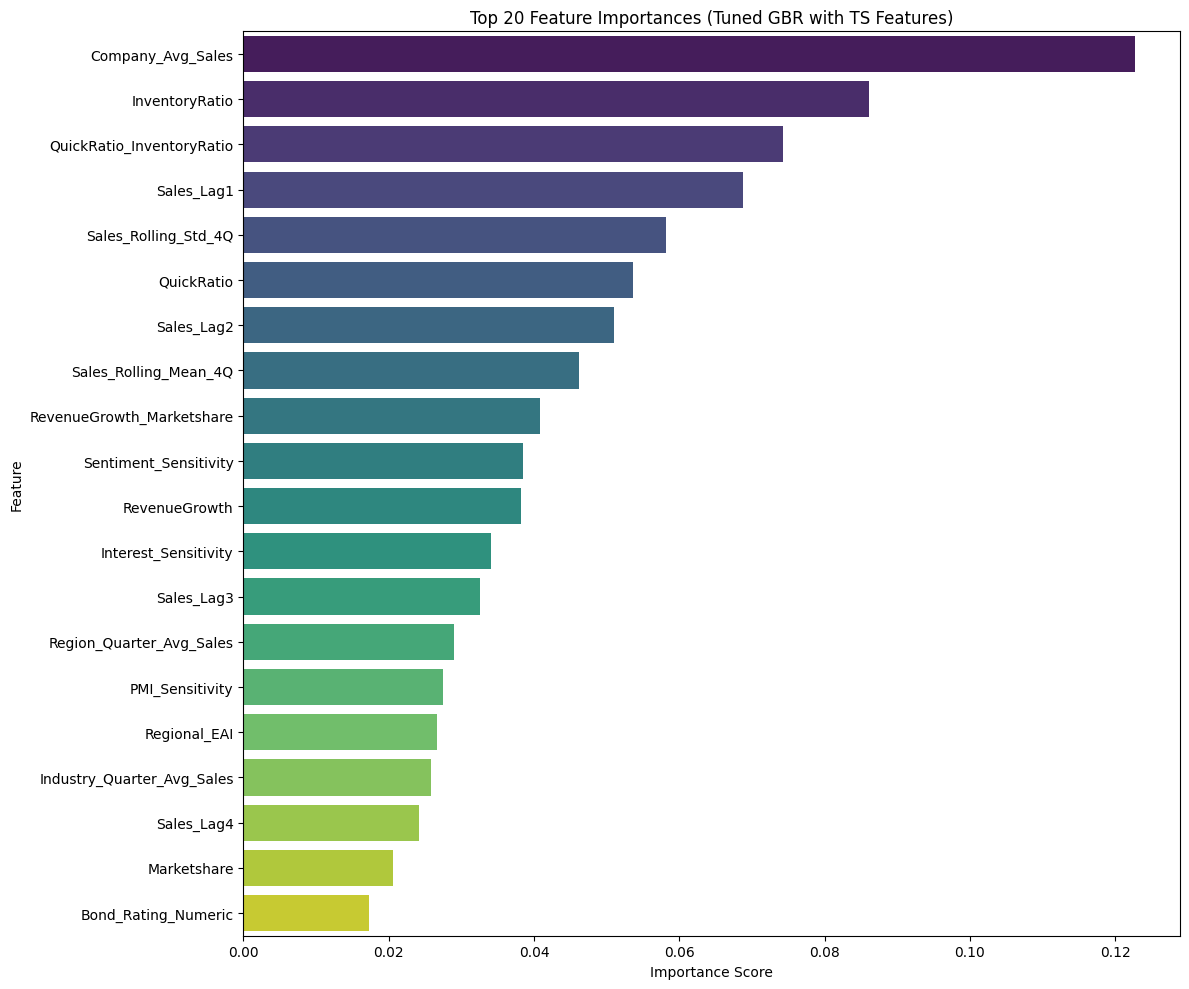


Top 10 Features (Tuned GBR with TS Features):
                  Feature  Importance
        Company_Avg_Sales    0.122777
           InventoryRatio    0.086097
QuickRatio_InventoryRatio    0.074251
               Sales_Lag1    0.068711
     Sales_Rolling_Std_4Q    0.058228
               QuickRatio    0.053668
               Sales_Lag2    0.050997
    Sales_Rolling_Mean_4Q    0.046137
RevenueGrowth_Marketshare    0.040781
    Sentiment_Sensitivity    0.038534

Generating predictions for test set...
Submission file 'Submission_TunedGBR_WithTSFeatures_CVMAE_554.53.csv' created successfully.
    RowID        Sales
7       1  2506.276609
8       2  1972.007300
16      3  6393.629538
17      4  4432.097186
25      5  4964.677529

Script finished.


In [1]:
# Cell: 1 - Import Libraries and Set up Environment (Mostly unchanged)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import warnings
import os # Added for file path checks

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Cell: 2 - Load Data (Unchanged from previous focused version)
def load_data():
    try:
        train = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/train.csv')
        test = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/test.csv')
        indicators = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/EconomicIndicators.csv')
        print("Data loaded successfully.")
        # Display file paths for confirmation
        print("Input files found:")
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                print(os.path.join(dirname, filename))
        return train, test, indicators
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure the input files are in the correct directory: /kaggle/input/sp-25-sales-forecasting/")
        return None, None, None

# Check if running in Kaggle environment and list files
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running in Kaggle environment.")
    if not os.path.exists('/kaggle/input/sp-25-sales-forecasting'):
         print("Error: Input directory '/kaggle/input/sp-25-sales-forecasting' not found.")
         train, test, indicators = None, None, None
    else:
        train, test, indicators = load_data()
else:
    print("Not running in Kaggle environment. Assuming local setup.")
    # Adjust paths if running locally - replace with your actual paths
    local_path = './data/' # Example local path
    try:
        train = pd.read_csv(os.path.join(local_path, 'train.csv'))
        test = pd.read_csv(os.path.join(local_path, 'test.csv'))
        indicators = pd.read_csv(os.path.join(local_path, 'EconomicIndicators.csv'))
        print("Local data loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Local data files not found in '{local_path}'. Please adjust the path.")
        train, test, indicators = None, None, None

# Proceed only if data loaded successfully
if train is not None and test is not None and indicators is not None:
    print("\nTrain data shape:", train.shape)
    print("Test data shape:", test.shape)
    print("Indicators data shape:", indicators.shape)
else:
    print("\nExiting due to data loading issues.")
    # Optional: exit() or raise Exception


# Cell: 4 - Feature Engineering (MODIFIED to include Time Series Features)
import pandas as pd
import numpy as np

def feature_engineering_with_ts(train_df, test_df, indicators_df):
    print("\nStarting Feature Engineering with Time Series Features...")

    # == Part 1: Combine, Sort, and Basic TS Prep ==
    print("Combining train/test for TS feature calculation...")
    train_df['Source'] = 'train'
    test_df['Source'] = 'test'
    combined_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

    # Convert Quarter to numeric for sorting
    combined_df['Quarter_Num'] = combined_df['Quarter'].str.extract(r'Q(\d+)').astype(int)

    # Sort by Company and Quarter - ESSENTIAL for lags/rolling windows
    combined_df = combined_df.sort_values(['Company', 'Quarter_Num']).reset_index(drop=True)
    print(f"Combined shape after sorting: {combined_df.shape}")


    # == Part 2: Time Series Feature Creation (Lags & Rolling Windows) ==
    print("Creating lag features...")
    lags_to_create = [1, 2, 3, 4] # Lags for 1, 2, 3, 4 quarters ago
    for lag in lags_to_create:
        combined_df[f'Sales_Lag{lag}'] = combined_df.groupby('Company')['Sales'].shift(lag)
        print(f"  - Created Sales_Lag{lag}")

    print("Creating rolling window features (based on past sales)...")
    # Use shift(1) before rolling to prevent data leakage from the current row
    sales_shifted = combined_df.groupby('Company')['Sales'].shift(1)

    # Rolling Mean (previous 4 quarters)
    combined_df['Sales_Rolling_Mean_4Q'] = sales_shifted.groupby(combined_df['Company']).rolling(
        window=4, min_periods=1 # Use min_periods=1 to get values even with less than 4 past points
    ).mean().reset_index(level=0, drop=True) # reset_index needed for direct assignment
    print(f"  - Created Sales_Rolling_Mean_4Q")

    # Rolling Std Dev (previous 4 quarters)
    combined_df['Sales_Rolling_Std_4Q'] = sales_shifted.groupby(combined_df['Company']).rolling(
        window=4, min_periods=2 # Need at least 2 points for std dev
    ).std().reset_index(level=0, drop=True)
    print(f"  - Created Sales_Rolling_Std_4Q")

    # Fill NaNs created by rolling std with 0 (where std dev is undefined/0)
    combined_df['Sales_Rolling_Std_4Q'].fillna(0, inplace=True)


    # == Part 3: Original Feature Engineering Steps (Applied to combined_df) ==
    print("Applying original feature engineering steps...")
    # 1) Convert Month -> quarter number for indicators
    def month_to_quarter(month):
        return (month - 1) // 3 + 1
    indicators_df['Quarter_Map'] = indicators_df['Month'].apply(month_to_quarter) # Use different name to avoid clash

    # 2) Aggregate indicators by quarter
    quarterly_indicators = (
        indicators_df
        .groupby('Quarter_Map')
        .agg({
            'Consumer Sentiment': 'mean', 'Interest Rate': 'mean', 'PMI': 'mean',
            'Money Supply': 'mean', 'NationalEAI': 'mean', 'EastEAI': 'mean',
            'WestEAI': 'mean', 'SouthEAI': 'mean', 'NorthEAI': 'mean'
        })
        .reset_index()
    )
    quarterly_indicators['Quarter'] = 'Q' + quarterly_indicators['Quarter_Map'].astype(str) # Match format
    quarterly_indicators = quarterly_indicators.drop(columns=['Quarter_Map'])

    # 4) Merge indicators into combined_df
    combined_df = pd.merge(combined_df, quarterly_indicators, on='Quarter', how='left')
    print("Merged economic indicators.")

    # 5) Group Average Sales (calculated ONLY from train data)
    # Calculate averages on the original train_df BEFORE it was combined
    company_avg = train_df.groupby('Company')['Sales'].mean().rename('Company_Avg_Sales')
    industry_avg = train_df.groupby('Industry')['Sales'].mean().rename('Industry_Avg_Sales')
    region_avg = train_df.groupby('Region')['Sales'].mean().rename('Region_Avg_Sales')
    quarter_avg = train_df.groupby('Quarter')['Sales'].mean().rename('Quarter_Avg_Sales')
    ind_q_avg = train_df.groupby(['Industry', 'Quarter'])['Sales'].mean().rename('Industry_Quarter_Avg_Sales')
    reg_q_avg = train_df.groupby(['Region', 'Quarter'])['Sales'].mean().rename('Region_Quarter_Avg_Sales')

    # Merge these averages into the combined_df
    combined_df = pd.merge(combined_df, company_avg, on='Company', how='left')
    combined_df = pd.merge(combined_df, industry_avg, on='Industry', how='left')
    combined_df = pd.merge(combined_df, region_avg, on='Region', how='left')
    combined_df = pd.merge(combined_df, quarter_avg, on='Quarter', how='left')
    combined_df = pd.merge(combined_df, ind_q_avg, on=['Industry', 'Quarter'], how='left')
    combined_df = pd.merge(combined_df, reg_q_avg, on=['Region', 'Quarter'], how='left')
    print("Added group-based average sales features (from train).")

    # 7) Interaction features
    # Impute InventoryRatio temporarily for interaction term if missing
    combined_df['InventoryRatio_imputed_temp'] = combined_df['InventoryRatio'].fillna(combined_df['InventoryRatio'].median())
    combined_df['QuickRatio_InventoryRatio'] = combined_df['QuickRatio'] * combined_df['InventoryRatio_imputed_temp']
    combined_df['RevenueGrowth_Marketshare'] = combined_df['RevenueGrowth'] * combined_df['Marketshare']
    combined_df.drop(columns=['InventoryRatio_imputed_temp'], inplace=True) # Remove temporary column

    # 8) Map ordinal ratings
    bond_map  = {'AAA':7,'AA':6,'A':5,'BBB':4,'BB':3,'B':2,'CCC':1}
    stock_map = {'Strong Buy':5,'Buy':4,'Hold':3,'Underperform':2,'Sell':1}
    combined_df['Bond_Rating_Numeric']  = combined_df['Bond rating'].map(bond_map)
    combined_df['Stock_Rating_Numeric'] = combined_df['Stock rating'].map(stock_map)
    print("Added interaction and rating features.")

    # 9) Regional EAI
    def regional_eai(r):
        region = r['Region']
        if region == 'East': return r['EastEAI']
        if region == 'West': return r['WestEAI']
        if region == 'South': return r['SouthEAI']
        if region == 'North': return r['NorthEAI']
        return r['NationalEAI'] # Fallback
    combined_df['Regional_EAI'] = combined_df.apply(regional_eai, axis=1)

    # 10) Company‑level economic sensitivity (calculated ONLY from train data)
    sens = {}
    train_sens_data = combined_df[combined_df['Source'] == 'train'].copy() # Use data merged with indicators
    for comp, grp in train_sens_data.groupby('Company'):
        cs, cp, ci = 0, 0, 0
        if len(grp) >= 3 and grp['Sales'].nunique() > 1:
             valid_cs = grp['Consumer Sentiment'].nunique() > 1 and not grp['Consumer Sentiment'].isnull().all()
             valid_pmi = grp['PMI'].nunique() > 1 and not grp['PMI'].isnull().all()
             valid_ir = grp['Interest Rate'].nunique() > 1 and not grp['Interest Rate'].isnull().all()
             valid_sales = not grp['Sales'].isnull().all()

             if valid_cs and valid_sales:
                 cs_corr = np.corrcoef(grp['Consumer Sentiment'].fillna(0), grp['Sales'].fillna(0))[0,1]
                 cs = 0 if np.isnan(cs_corr) else cs_corr
             if valid_pmi and valid_sales:
                 cp_corr = np.corrcoef(grp['PMI'].fillna(0), grp['Sales'].fillna(0))[0,1]
                 cp = 0 if np.isnan(cp_corr) else cp_corr
             if valid_ir and valid_sales:
                 ci_corr = np.corrcoef(grp['Interest Rate'].fillna(0), grp['Sales'].fillna(0))[0,1]
                 ci = 0 if np.isnan(ci_corr) else ci_corr
        sens[comp] = {
            'Sentiment_Sensitivity': cs, 'PMI_Sensitivity': cp, 'Interest_Sensitivity': ci
        }

    # Map sensitivities
    combined_df['Sentiment_Sensitivity'] = combined_df['Company'].map(lambda c: sens.get(c, {}).get('Sentiment_Sensitivity', 0))
    combined_df['PMI_Sensitivity']       = combined_df['Company'].map(lambda c: sens.get(c, {}).get('PMI_Sensitivity', 0))
    combined_df['Interest_Sensitivity']  = combined_df['Company'].map(lambda c: sens.get(c, {}).get('Interest_Sensitivity', 0))
    print("Added regional EAI and sensitivity features.")


    # == Part 4: Final Split and NaN Handling ==
    # Separate back into train and test
    train_enriched = combined_df[combined_df['Source'] == 'train'].drop(columns=['Source'])
    test_enriched = combined_df[combined_df['Source'] == 'test'].drop(columns=['Source', 'Sales']) # Drop Sales from test

    # Handle NaNs created by merges in the test set specifically
    merge_nan_cols = [
        'Company_Avg_Sales', 'Industry_Avg_Sales', 'Region_Avg_Sales',
        'Quarter_Avg_Sales', 'Industry_Quarter_Avg_Sales',
        'Region_Quarter_Avg_Sales', 'Sentiment_Sensitivity',
        'PMI_Sensitivity', 'Interest_Sensitivity'
        # Note: Lag/Rolling NaNs will be handled by the imputer pipeline later
    ]
    # Calculate global means from the *enriched* training set for filling
    train_means = train_enriched[merge_nan_cols].mean()

    for col in merge_nan_cols:
        if test_enriched[col].isnull().any():
            if col == 'Company_Avg_Sales':
                 test_enriched[col] = test_enriched[col].fillna(test_enriched['Industry_Avg_Sales'])
            test_enriched[col].fillna(train_means[col], inplace=True)
            # print(f"Filled NaNs in test set for '{col}' using train means or backup logic.")


    print(f"Train shape after FE: {train_enriched.shape}")
    print(f"Test shape after FE: {test_enriched.shape}")
    print("Feature Engineering complete.")

    # Check for remaining NaNs (especially in new TS features) - expected at start of series
    # print("\nNaN counts in enriched train data (first 5 rows):")
    # print(train_enriched.head().isnull().sum())
    # print("\nNaN counts in enriched test data (first 5 rows):")
    # print(test_enriched.head().isnull().sum())


    return train_enriched, test_enriched

# Run the feature engineering only if data was loaded
if train is not None:
    train_enriched, test_enriched = feature_engineering_with_ts(train, test, indicators)
else:
    print("Skipping feature engineering due to data loading issues.")

# Cell: 5 - Prepare Data for Modeling (MODIFIED feature list)
def prepare_modeling_data(train_enriched, test_enriched):
    print("\nPreparing data for modeling...")
    if train_enriched is None or test_enriched is None:
        print("Enriched dataframes are missing. Cannot prepare modeling data.")
        return None, None, None, None, None

    # Target variable (ensure it's present before using it)
    if 'Sales' not in train_enriched.columns:
         print("Error: 'Sales' column missing from enriched training data.")
         return None, None, None, None, None
    y = train_enriched['Sales']
    X = train_enriched.drop(columns=['Sales']) # Drop target here

    # Define features (INCLUDING NEW TS FEATURES)
    numerical_features = [
        'QuickRatio', 'InventoryRatio', 'RevenueGrowth', 'Marketshare',
        'Consumer Sentiment', 'Interest Rate', 'PMI', 'Money Supply',
        'NationalEAI', 'EastEAI', 'WestEAI', 'SouthEAI', 'NorthEAI',
        'Company_Avg_Sales', 'Industry_Avg_Sales', 'Region_Avg_Sales',
        'Quarter_Avg_Sales', 'Industry_Quarter_Avg_Sales',
        'Region_Quarter_Avg_Sales', 'QuickRatio_InventoryRatio',
        'RevenueGrowth_Marketshare',
        'Bond_Rating_Numeric', 'Stock_Rating_Numeric',
        'Regional_EAI', 'Sentiment_Sensitivity',
        'PMI_Sensitivity', 'Interest_Sensitivity',
        'Quarter_Num',
        # -- New Time Series Features --
        'Sales_Lag1', 'Sales_Lag2', 'Sales_Lag3', 'Sales_Lag4',
        'Sales_Rolling_Mean_4Q', 'Sales_Rolling_Std_4Q'
    ]

    categorical_features = ['Industry', 'Region'] # Keep potentially useful categoricals

    # Original Identifier columns to drop (if they weren't dropped already)
    other_cols_to_drop = ['Quarter', 'Company', 'Bond rating', 'Stock rating', 'RowID']

    # Filter numerical/categorical lists to those *actually present* in X
    numerical_features = [c for c in numerical_features if c in X.columns]
    categorical_features = [c for c in categorical_features if c in X.columns]

    # Select only the columns needed for modeling from X and X_test
    all_features = numerical_features + categorical_features
    X = X[all_features]
    # Ensure test_enriched has the same columns (important!)
    # First, drop columns from test_enriched that are not in all_features
    test_enriched_cols = [c for c in all_features if c in test_enriched.columns]
    X_test = test_enriched[test_enriched_cols]
    # Now, reindex to match X's columns exactly, filling missing ones (shouldn't happen ideally)
    X_test = X_test.reindex(columns=X.columns, fill_value=np.nan)


    print(f"Using {len(numerical_features)} numerical features.")
    print(f"Using {len(categorical_features)} categorical features.")
    print(f"Shape of X (train features): {X.shape}")
    print(f"Shape of y (train target): {y.shape}")
    print(f"Shape of X_test (test features): {X_test.shape}")


    # Create preprocessing pipeline (Unchanged - handles new features)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Median is robust to outliers
        ('scaler',  StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough') # No remainder expected

    print("Preprocessor defined.")
    # Return the original test_enriched for RowID later
    return X, y, X_test, preprocessor, test_enriched # Pass original test_enriched

# Execute data preparation only if FE was successful
if 'train_enriched' in locals() and train_enriched is not None:
     X_train, y_train, X_test, preprocessor, test_enriched_final = prepare_modeling_data(train_enriched, test_enriched)
else:
     print("Skipping data preparation due to missing enriched data.")
     X_train, y_train, X_test, preprocessor, test_enriched_final = None, None, None, None, None


# Cell: 6 - Gradient Boosting Regressor Tuning and Training (Unchanged)
def tune_and_train_gbr(X_train, y_train, preprocessor):
    print("\nTuning and Training Gradient Boosting Regressor with TS Features...")
    if X_train is None or y_train is None or preprocessor is None:
        print("Input data or preprocessor is missing. Skipping GBR tuning.")
        return None, None, None # Return None for search object too

    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'model__n_estimators': [100, 200, 300, 400, 500, 600], # Slightly wider range
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1], # Focused lower rates often better
        'model__max_depth': [3, 4, 5, 6], # Keep reasonable depth
        'model__min_samples_split': [2, 5, 10, 15],
        'model__min_samples_leaf': [1, 3, 5, 7],
        'model__subsample': [0.7, 0.8, 0.9, 1.0], # Stochasiticity helps
        'model__max_features': ['sqrt', 'log2', 0.8, None] # Added fraction option
    }

    # Create the full pipeline: Preprocessor -> GBR
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=SEED, loss='absolute_error')) # MAE loss
    ])

    # Set up KFold cross-validation
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings sampled (increase for more exhaustive search)
        cv=cv_strategy,
        scoring='neg_mean_absolute_error', # Optimize for MAE
        n_jobs=-1, # Use all available CPU cores
        random_state=SEED,
        verbose=1 # Show progress
    )

    print("Starting Randomized Search CV...")
    random_search.fit(X_train, y_train) # Fit on the full training data

    print("\nRandomized Search CV complete.")
    best_score = -random_search.best_score_ if hasattr(random_search, 'best_score_') else float('inf')
    print(f"Best MAE score from CV: {best_score:.4f}")
    print("Best parameters found:")
    best_params = random_search.best_params_ if hasattr(random_search, 'best_params_') else {}
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Get the best estimator pipeline
    best_gbr_pipeline = random_search.best_estimator_ if hasattr(random_search, 'best_estimator_') else None

    if best_gbr_pipeline:
        print("\nBest GBR pipeline is already refit on the full training data.")
    else:
        print("\nCould not retrieve best GBR pipeline from search.")


    return best_gbr_pipeline, best_params, random_search # Return search object for score

# Run tuning and training only if data is prepared
best_gbr_pipeline, best_gbr_params, search_results = (None, None, None) # Initialize
if X_train is not None:
    best_gbr_pipeline, best_gbr_params, search_results = tune_and_train_gbr(X_train, y_train, preprocessor)
else:
    print("Skipping GBR tuning due to missing training data.")


# Cell: 7 - Feature Importance Analysis for Tuned GBR (Unchanged Function, will use new features)
def analyze_feature_importance_tuned(pipeline, X_train):
    # (Function definition is the same as before)
    print("\nAnalyzing Feature Importance for the Tuned GBR Model (with TS Features)...")
    if pipeline is None or X_train is None:
        print("Pipeline or training data missing. Skipping feature importance.")
        return

    try:
        preprocessor = pipeline.named_steps['preprocessor']
        gbr_model = pipeline.named_steps['model']

        num_features_tf = preprocessor.transformers_[0][2]
        cat_transformer = preprocessor.transformers_[1][1]
        ohe_step = cat_transformer.named_steps['onehot']
        cat_features_original = preprocessor.transformers_[1][2]

        if hasattr(ohe_step, 'get_feature_names_out'):
            ohe_feature_names = ohe_step.get_feature_names_out(cat_features_original)
        else: # Fallback for older sklearn versions
             ohe_feature_names = ohe_step.get_feature_names(cat_features_original)


        all_feature_names = list(num_features_tf) + list(ohe_feature_names)

        if hasattr(gbr_model, 'feature_importances_'):
            importances = gbr_model.feature_importances_

            if len(importances) != len(all_feature_names):
                print(f"Warning: Mismatch in feature importance length ({len(importances)}) and feature name length ({len(all_feature_names)}). Skipping plot.")
                print(f"Num Features: {len(num_features_tf)}, Cat Features (OHE): {len(ohe_feature_names)}")
                # print("Numerical features:", num_features_tf)
                # print("OHE features:", ohe_feature_names)
                return

            fi_df = pd.DataFrame({
                'Feature': all_feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False).reset_index(drop=True)

            plt.figure(figsize=(12, 10))
            sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
            plt.title('Top 20 Feature Importances (Tuned GBR with TS Features)')
            plt.xlabel('Importance Score')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()

            print("\nTop 10 Features (Tuned GBR with TS Features):")
            print(fi_df.head(10).to_string(index=False))
        else:
            print("The trained GBR model does not have feature_importances_ attribute.")

    except Exception as e:
        print(f"An error occurred during feature importance analysis: {e}")
        import traceback
        traceback.print_exc()


# Analyze importance only if tuning was successful
if best_gbr_pipeline is not None:
    analyze_feature_importance_tuned(best_gbr_pipeline, X_train)
else:
    print("Skipping feature importance analysis as the GBR model was not trained.")


# Cell: 8 - Generate Submission File (Unchanged Function)
def generate_submission(pipeline, X_test, test_df_original, filename="submission_tuned_gbr_ts.csv"):
    # (Function definition is the same as before)
    print(f"\nGenerating predictions for test set...")
    if pipeline is None or X_test is None or test_df_original is None:
        print("Pipeline, test features, or original test dataframe missing. Cannot generate submission.")
        return

    # Ensure test_df_original has 'RowID' - use the one passed from prepare_modeling_data
    if 'RowID' not in test_df_original.columns:
        print("Error: 'RowID' column not found in the test dataframe used for submission.")
        # Attempt to merge RowID back from the original test file if lengths match
        try:
            original_test_file = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/test.csv')
            if len(test_df_original) == len(original_test_file):
                 print("Attempting to merge RowID from original test file.")
                 # Need a common key - Quarter and Company should be unique per row in test
                 test_df_original = pd.merge(test_df_original, original_test_file[['Quarter', 'Company', 'RowID']],
                                              on=['Quarter', 'Company'], how='left')
                 if 'RowID' not in test_df_original.columns or test_df_original['RowID'].isnull().any():
                     print("Failed to merge RowID based on Quarter/Company.")
                     # Last resort: regenerate based on index if still missing
                     if 'RowID' not in test_df_original.columns:
                          test_df_original['RowID'] = test_df_original.index + 1 # ASSUMES order preserved & starts at 1
                     else:
                          print("Cannot guarantee correct RowID. Submission may be invalid.")
                          return # Avoid submitting potentially wrong IDs
            else:
                print("Length mismatch with original test file, cannot merge RowID.")
                return
        except Exception as e:
             print(f"Error trying to recover RowID: {e}")
             return


    try:
        test_predictions = pipeline.predict(X_test)
        test_predictions = np.maximum(0, test_predictions) # Ensure non-negative

        submission_df = pd.DataFrame({
            'RowID': test_df_original['RowID'],
            'Sales': test_predictions
        })
        submission_df['RowID'] = submission_df['RowID'].astype(int) # Ensure integer RowID

        submission_df.to_csv(filename, index=False)
        print(f"Submission file '{filename}' created successfully.")
        print(submission_df.head())

    except Exception as e:
        print(f"An error occurred during submission generation: {e}")
        import traceback
        traceback.print_exc()

# Generate submission only if pipeline and test data are available
if best_gbr_pipeline is not None and X_test is not None and test_enriched_final is not None:
    # Extract the best CV score to include in the filename
    best_cv_mae = -search_results.best_score_ if search_results and hasattr(search_results, 'best_score_') else 0.0
    submission_filename = f"Submission_TunedGBR_WithTSFeatures_CVMAE_{best_cv_mae:.2f}.csv"
    # Pass test_enriched_final which should contain RowID after FE step
    generate_submission(best_gbr_pipeline, X_test, test_enriched_final, filename=submission_filename)
else:
    print("Skipping submission generation due to missing components.")

print("\nScript finished.")

In [2]:
# Cell: 1 - Import Libraries and Set up Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    StackingRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgbm
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Cell: 2 - Load Data (Same as before)
def load_data():
    try:
        train = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/train.csv')
        test = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/test.csv')
        indicators = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/EconomicIndicators.csv')
        print("Data loaded successfully.")
        # Display file paths for confirmation
        print("Input files found:")
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                print(os.path.join(dirname, filename))
        return train, test, indicators
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure the input files are in the correct directory: /kaggle/input/sp-25-sales-forecasting/")
        return None, None, None

# Check if running in Kaggle environment and list files
import os
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running in Kaggle environment.")
    if not os.path.exists('/kaggle/input/sp-25-sales-forecasting'):
         print("Error: Input directory '/kaggle/input/sp-25-sales-forecasting' not found.")
    else:
        train, test, indicators = load_data()
else:
    print("Not running in Kaggle environment. Assuming local setup.")
    # Adjust paths if running locally - replace with your actual paths
    local_path = './data/' # Example local path
    try:
        train = pd.read_csv(os.path.join(local_path, 'train.csv'))
        test = pd.read_csv(os.path.join(local_path, 'test.csv'))
        indicators = pd.read_csv(os.path.join(local_path, 'EconomicIndicators.csv'))
        print("Local data loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Local data files not found in '{local_path}'. Please adjust the path.")
        train, test, indicators = None, None, None

# Proceed only if data loaded successfully
if train is not None and test is not None and indicators is not None:
    print("\nTrain data shape:", train.shape)
    print("Test data shape:", test.shape)
    print("Indicators data shape:", indicators.shape)
else:
    print("\nExiting due to data loading issues.")

# Cell: 3 - Enhanced Feature Engineering
def advanced_feature_engineering(train, test, indicators):
    print("\nStarting Enhanced Feature Engineering...")
    # Start with basic feature engineering
    # 1) Convert Month -> quarter number
    def month_to_quarter(month):
        return (month - 1) // 3 + 1
    indicators['Quarter'] = indicators['Month'].apply(month_to_quarter)

    # 2) Aggregate indicators by quarter with multiple metrics
    quarterly_indicators = (
        indicators
        .groupby('Quarter')
        .agg({
            'Consumer Sentiment': ['mean', 'min', 'max', 'std'],
            'Interest Rate':      ['mean', 'min', 'max', 'std'],
            'PMI':                ['mean', 'min', 'max', 'std'],
            'Money Supply':       ['mean', 'min', 'max', 'std'],
            'NationalEAI':        ['mean', 'min', 'max', 'std'],
            'EastEAI':            ['mean', 'min', 'max', 'std'],
            'WestEAI':            ['mean', 'min', 'max', 'std'],
            'SouthEAI':           ['mean', 'min', 'max', 'std'],
            'NorthEAI':           ['mean', 'min', 'max', 'std']
        })
    )
    
    # Flatten multi-index columns
    quarterly_indicators.columns = ['_'.join(col).strip() for col in quarterly_indicators.columns.values]
    quarterly_indicators.reset_index(inplace=True)
    
    # 3) Turn to "Q1", "Q2", ... to match train/test
    quarterly_indicators['Quarter'] = 'Q' + quarterly_indicators['Quarter'].astype(str)

    # 4) Merge indicators
    train_enriched = pd.merge(train.copy(), quarterly_indicators, on='Quarter', how='left')
    test_enriched  = pd.merge(test.copy(),  quarterly_indicators, on='Quarter', how='left')
    print(f"Train shape after merging indicators: {train_enriched.shape}")
    print(f"Test shape after merging indicators: {test_enriched.shape}")

    # 5) Company / Industry / Region / Quarter average sales and other statistics
    def add_group_stats(df_out, df_in_train, by, prefix):
        # Calculate stats only on the training data to prevent leakage
        stats = df_in_train.groupby(by)['Sales'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
        stats.columns = [by] + [f"{prefix}_{stat}" for stat in ['mean', 'median', 'std', 'min', 'max']]
        merged_df = pd.merge(df_out, stats, on=by, how='left')
        return merged_df

    for group, prefix in [('Company', 'Company'), ('Industry', 'Industry'), 
                          ('Region', 'Region'), ('Quarter', 'Quarter')]:
        train_enriched = add_group_stats(train_enriched, train, group, prefix)
        test_enriched = add_group_stats(test_enriched, train, group, prefix)

    # 6) Multi-level aggregations for combined factors
    # Industry-Quarter stats
    ind_q_stats = train.groupby(['Industry','Quarter'])['Sales'].agg(['mean', 'median', 'std']).reset_index()
    ind_q_stats.columns = ['Industry', 'Quarter'] + [f"Industry_Quarter_{stat}" for stat in ['mean', 'median', 'std']]
    
    # Region-Quarter stats
    reg_q_stats = train.groupby(['Region','Quarter'])['Sales'].agg(['mean', 'median', 'std']).reset_index() 
    reg_q_stats.columns = ['Region', 'Quarter'] + [f"Region_Quarter_{stat}" for stat in ['mean', 'median', 'std']]
    
    # Company-Quarter stats
    comp_q_stats = train.groupby(['Company','Quarter'])['Sales'].agg(['mean']).reset_index()
    comp_q_stats.columns = ['Company', 'Quarter', 'Company_Quarter_mean']

    # Merge all stats
    for stats_df in [ind_q_stats, reg_q_stats, comp_q_stats]:
        train_enriched = pd.merge(train_enriched, stats_df, on=list(stats_df.columns[:2]), how='left')
        test_enriched = pd.merge(test_enriched, stats_df, on=list(stats_df.columns[:2]), how='left')
    
    print("Added multi-level group statistics.")

    # 7) Advanced Interaction features
    for df in (train_enriched, test_enriched):
        # Impute InventoryRatio temporarily for interaction term if missing
        df['InventoryRatio_imputed_temp'] = df['InventoryRatio'].fillna(df['InventoryRatio'].median())
        
        # Basic interactions
        df['QuickRatio_InventoryRatio'] = df['QuickRatio'] * df['InventoryRatio_imputed_temp']
        df['RevenueGrowth_Marketshare'] = df['RevenueGrowth'] * df['Marketshare']
        
        # Indicator interactions with company metrics
        df['QuickRatio_InterestRate'] = df['QuickRatio'] * df['Interest Rate_mean']
        df['RevenueGrowth_ConsumerSentiment'] = df['RevenueGrowth'] * df['Consumer Sentiment_mean']
        df['Marketshare_PMI'] = df['Marketshare'] * df['PMI_mean']
        
        # Ratio metrics
        df['Inventory_Market_Ratio'] = df['InventoryRatio_imputed_temp'] / (df['Marketshare'] + 0.001)
        df['Growth_Inventory_Ratio'] = df['RevenueGrowth'] / (df['InventoryRatio_imputed_temp'] + 0.001)
        
        # Combined economic influence metric
        df['Econ_Composite'] = (df['Consumer Sentiment_mean'] * 0.3 + 
                              df['PMI_mean'] * 0.4 - 
                              df['Interest Rate_mean'] * 0.3)
        
        df.drop(columns=['InventoryRatio_imputed_temp'], inplace=True)

    # 8) Map ordinal ratings and create new features
    bond_map  = {'AAA':7,'AA':6,'A':5,'BBB':4,'BB':3,'B':2,'CCC':1}
    stock_map = {'Strong Buy':5,'Buy':4,'Hold':3,'Underperform':2,'Sell':1}
    for df in (train_enriched, test_enriched):
        df['Bond_Rating_Numeric']  = df['Bond rating'].map(bond_map)
        df['Stock_Rating_Numeric'] = df['Stock rating'].map(stock_map)
        
        # Combined rating score
        df['Combined_Rating'] = df['Bond_Rating_Numeric'] * df['Stock_Rating_Numeric']
        
        # Rating difference (divergence between bond and stock assessment)
        df['Rating_Divergence'] = (df['Bond_Rating_Numeric'] / 7) - (df['Stock_Rating_Numeric'] / 5)

    print("Added advanced interaction and rating features.")

    # 9) Region-specific economic indicators and features
    def regional_eai_all(r):
        region = r['Region']
        eai_dict = {
            'East': r['EastEAI_mean'],  
            'West': r['WestEAI_mean'],
            'South': r['SouthEAI_mean'],
            'North': r['NorthEAI_mean']
        }
        
        # Get specific region EAI
        regional = eai_dict.get(region, r['NationalEAI_mean'])
        
        # Calculate region vs national difference
        diff = regional - r['NationalEAI_mean']
        
        return pd.Series({
            'Regional_EAI': regional,
            'Regional_National_EAI_Diff': diff,
            'Regional_EAI_Relative': regional / (r['NationalEAI_mean'] + 0.001)
        })

    for df in (train_enriched, test_enriched):
        df[['Regional_EAI', 'Regional_National_EAI_Diff', 'Regional_EAI_Relative']] = df.apply(regional_eai_all, axis=1)
        
        # Create region-specific economic indicators
        for region in ['East', 'West', 'North', 'South']:
            df[f'{region}_Region_Flag'] = (df['Region'] == region).astype(int)
            for metric in ['Consumer Sentiment_mean', 'PMI_mean', 'Interest Rate_mean']:
                df[f'{region}_{metric}'] = (df[f'{region}_Region_Flag'] * df[metric])

    # 10) Economic sensitivity metrics & market positioning
    # Get economic relationships at company level
    sensitivity_metrics = {}
    positioning_metrics = {}
    
    for company, grp in train_enriched.groupby('Company'):
        sens_metrics = {}
        pos_metrics = {}
        
        # Basic sensitivities (correlations)
        if len(grp) >= 3 and grp['Sales'].nunique() > 1:
            # Economic sensitivities
            for metric in ['Consumer Sentiment_mean', 'PMI_mean', 'Interest Rate_mean', 'Money Supply_mean', 
                          'NationalEAI_mean', 'Regional_EAI']:
                if grp[metric].nunique() > 1:
                    corr = np.corrcoef(grp[metric], grp['Sales'])[0,1]
                    sens_metrics[f'{metric}_Sensitivity'] = 0 if np.isnan(corr) else corr
            
            # Market positioning metrics
            industry_mean = train[train['Industry'] == grp['Industry'].iloc[0]]['Sales'].mean()
            mean_sales = grp['Sales'].mean()
            
            pos_metrics = {
                'IndustryPosition': mean_sales / (industry_mean + 0.001) if industry_mean else 1,
                'MarketShareToSalesRatio': grp['Marketshare'].mean() / (mean_sales / 10000 + 0.001),
                'RatingEffectiveness': grp['Stock_Rating_Numeric'].mean() * (mean_sales / 5000)
            }
        
        sensitivity_metrics[company] = sens_metrics
        positioning_metrics[company] = pos_metrics
    
    # Map sensitivities and positioning metrics
    for df in (train_enriched, test_enriched):
        # Sensitivities
        for metric in ['Consumer Sentiment_mean', 'PMI_mean', 'Interest Rate_mean', 
                       'Money Supply_mean', 'NationalEAI_mean', 'Regional_EAI']:
            col_name = f'{metric}_Sensitivity'
            df[col_name] = df['Company'].map(
                lambda c: sensitivity_metrics.get(c, {}).get(col_name, 0)
            )
        
        # Positioning
        for metric in ['IndustryPosition', 'MarketShareToSalesRatio', 'RatingEffectiveness']:
            df[metric] = df['Company'].map(
                lambda c: positioning_metrics.get(c, {}).get(metric, 1)
            )
    
    print("Added advanced economic sensitivity and market positioning features.")
    
    # 11) Quarter-based cyclic features 
    for df in (train_enriched, test_enriched):
        df['Quarter_Numeric'] = df['Quarter'].str.extract(r'Q(\d+)').astype(int)
        
        # Cyclical encoding (sin, cos transformations)
        df['Quarter_Sin'] = np.sin(2 * np.pi * df['Quarter_Numeric'] / 4)
        df['Quarter_Cos'] = np.cos(2 * np.pi * df['Quarter_Numeric'] / 4)
        
        # Quarter lag differences (imperfect but can catch seasonality)
        df['Quarter_Trend'] = df['Quarter_Numeric'] - 2.5  # Centered around 0
    
    # 12) Fill NaNs created by merges in the test set
    # Identify all possible NaN columns from all the merges
    all_cols = list(train_enriched.columns)
    numeric_cols = train_enriched.select_dtypes(include=[np.number]).columns.tolist()
    
    # Get mean values to use for filling NAs
    train_means = train_enriched[numeric_cols].mean()
    
    # Advanced NaN handling using KNN imputation for test data
    for df in [test_enriched]:
        # First pass - replace with means for numeric columns
        for col in numeric_cols:
            if df[col].isnull().any():
                # Try context-aware filling when possible
                if col.startswith('Company_'):
                    ind_col = col.replace('Company_', 'Industry_')
                    if ind_col in df.columns:
                        df[col] = df[col].fillna(df[ind_col])
                
                # Fill remaining NaNs with mean
                df[col].fillna(train_means.get(col, 0), inplace=True)
    
    print(f"Train shape after advanced FE: {train_enriched.shape}")
    print(f"Test shape after advanced FE: {test_enriched.shape}")
    print("Enhanced Feature Engineering complete.")
    return train_enriched, test_enriched

# Cell: 4 - Advanced Data Preparation with Feature Selection
def prepare_advanced_modeling_data(train_enriched, test_enriched):
    print("\nPreparing data with advanced feature processing...")
    
    # Skip if data not available
    if train_enriched is None or test_enriched is None:
        print("Enriched dataframes are missing. Cannot prepare modeling data.")
        return None, None, None, None, None, None, None
    
    # First, find & handle outliers in target variable
    Q1 = train_enriched['Sales'].quantile(0.25)
    Q3 = train_enriched['Sales'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a column to identify outliers for potential weighting or separate modeling
    train_enriched['is_outlier'] = ((train_enriched['Sales'] < lower_bound) | 
                                   (train_enriched['Sales'] > upper_bound)).astype(int)
    
    # Create training weights (giving less weight to outliers)
    train_enriched['sample_weight'] = 1.0
    train_enriched.loc[train_enriched['is_outlier'] == 1, 'sample_weight'] = 0.5
    
    # Target variable
    y = train_enriched['Sales']
    sample_weights = train_enriched['sample_weight']
    
    # Filter out non-feature columns
    non_feature_cols = ['Sales', 'RowID', 'is_outlier', 'sample_weight',
                        'Bond rating', 'Stock rating', 'Quarter']  
    
    # Get categorical and numerical columns
    categorical_cols = ['Industry', 'Region', 'Company']
    
    # All remaining columns are numerical
    feature_cols = [col for col in train_enriched.columns if col not in non_feature_cols]
    numerical_cols = [col for col in feature_cols if col not in categorical_cols]
    
    print(f"Using {len(numerical_cols)} numerical features")
    print(f"Using {len(categorical_cols)} categorical features")
    
    # Feature DataFrames
    X = train_enriched[feature_cols]
    X_test = test_enriched[feature_cols]
    
    # Align X_test columns with X
    X_test = X_test.reindex(columns=X.columns, fill_value=np.nan)
    
    print(f"Shape of X (train features): {X.shape}")
    print(f"Shape of y (train target): {y.shape}")
    print(f"Shape of X_test (test features): {X_test.shape}")
    
    # Set up preprocessing pipeline with advanced techniques
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True))
    ])
    
    # Handle categorical variables - high cardinality approach
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    # Split data for validation (separate from CV splits) to use for feature selection
    X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(
        X, y, test_size=0.2, random_state=SEED
    )
    
    # Basic model for feature selection
    selector_model = lgbm.LGBMRegressor(
        n_estimators=100, 
        learning_rate=0.1,
        random_state=SEED
    )
    
    # Create a basic pipeline for feature selection
    feature_selector_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', selector_model)
    ])
    
    # Fit on subset
    feature_selector_pipe.fit(X_train_fs, y_train_fs)
    
    # Get feature names from preprocessor
    feature_names = None
    try:
        # For newer scikit-learn versions
        feature_names = feature_selector_pipe.named_steps['preprocessor'].get_feature_names_out()
    except:
        # For older scikit-learn versions - manual concatenation
        num_features = len(numerical_cols)
        cat_feature_names = []
        for cat_col in categorical_cols:
            unique_values = np.unique(np.concatenate([X_train_fs[cat_col].dropna().unique(), 
                                                     X_val_fs[cat_col].dropna().unique()]))
            cat_feature_names.extend([f"{cat_col}_{val}" for val in unique_values])
        
        feature_names = numerical_cols + cat_feature_names
    
    # Select top features
    feature_importance = feature_selector_pipe.named_steps['model'].feature_importances_
    
    # Create a feature selector for the final pipeline
    # We'll be more selective in the feature selection to avoid overfitting
    selector = SelectFromModel(
        feature_selector_pipe.named_steps['model'], 
        threshold='mean', 
        prefit=True
    )
    
    # Return preprocessed data and metadata
    return (X, y, X_test, preprocessor, selector, test_enriched, 
            sample_weights, feature_names, feature_importance)

# Cell: 5 - Advanced Ensemble Model Development
def build_advanced_ensemble(X, y, preprocessor, selector, sample_weights):
    print("\nBuilding advanced ensemble model...")
    
    # Skip if data not available
    if X is None or y is None:
        print("Training data missing. Cannot build ensemble.")
        return None, None
    
    # Create validation set
    X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
        X, y, sample_weights, test_size=0.2, random_state=SEED
    )
    
    # Initialize base models
    lgb_model = lgbm.LGBMRegressor(
        n_estimators=500, 
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        verbose=-1
    )
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED
    )
    
    gbr_model = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        random_state=SEED
    )
    
    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=SEED
    )
    
    et_model = ExtraTreesRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=SEED
    )
    
    # Meta learner
    meta_learner = Ridge(alpha=1.0)
    
    # Create stacking ensemble
    stack_ensemble = StackingRegressor(
        estimators=[
            ('lgb', lgb_model),
            ('xgb', xgb_model),
            ('gbr', gbr_model),
            ('rf', rf_model),
            ('et', et_model)
        ],
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1
    )
    
    # Create full pipeline with preprocessing and feature selection
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', stack_ensemble)
    ])
    
    # Train model with sample weights 
    print("Training ensemble model...")
    final_pipeline.fit(X_train, y_train, model__sample_weight=sw_train)
    
    # Evaluate on validation set
    val_pred = final_pipeline.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    print(f"Validation MAE: {val_mae:.2f}")
    
    # Full model training
    final_pipeline.fit(X, y, model__sample_weight=sample_weights)
    print("Ensemble model training complete.")
    
    return final_pipeline, val_mae

# Cell: 6 - Hyperparameter Optimization with Optuna
def optimize_hyperparameters(X, y, preprocessor, selector, sample_weights):
    print("\nOptimizing hyperparameters with Optuna...")
    
    if X is None or y is None:
        print("Training data missing. Cannot optimize hyperparameters.")
        return None
    
    # Create train/val split for optimization
    X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
        X, y, sample_weights, test_size=0.2, random_state=SEED
    )
    
    # Fix preprocessor in place to avoid recomputing during optimization
    print("Pre-processing training data...")
    preprocessed_X_train = preprocessor.fit_transform(X_train)
    preprocessed_X_val = preprocessor.transform(X_val)
    
    if selector is not None:
        print("Applying feature selection...")
        preprocessed_X_train = selector.transform(preprocessed_X_train)
        preprocessed_X_val = selector.transform(preprocessed_X_val)
    
    def objective(trial):
        # LightGBM parameters
        lgb_params = {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 200, 600),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.1, log=True),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 50),
            'subsample': trial.suggest_float('lgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('lgb_reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('lgb_reg_lambda', 0.0, 1.0),
            'verbose': -1,
            'random_state': SEED
        }
        
        # XGBoost parameters
        xgb_params = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 200, 600),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 8),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('xgb_reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('xgb_reg_lambda', 0.0, 1.0),
            'random_state': SEED
        }
        
        # Gradient Boosting parameters
        gbr_params = {
            'n_estimators': trial.suggest_int('gbr_n_estimators', 200, 600),
            'learning_rate': trial.suggest_float('gbr_learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('gbr_max_depth', 3, 8),
            'subsample': trial.suggest_float('gbr_subsample', 0.6, 1.0),
            'random_state': SEED
        }
        
        # Meta learner params
        meta_alpha = trial.suggest_float('meta_alpha', 0.01, 10.0, log=True)
        
        # Create models
        lgb_model = lgbm.LGBMRegressor(**lgb_params)
        xgb_model = xgb.XGBRegressor(**xgb_params)
        gbr_model = GradientBoostingRegressor(**gbr_params)
        
        # Meta learner
        meta_learner = Ridge(alpha=meta_alpha)
        
        # Create and train stack ensemble
        stack = StackingRegressor(
            estimators=[
                ('lgb', lgb_model),
                ('xgb', xgb_model),
                ('gbr', gbr_model)
            ],
            final_estimator=meta_learner,
            cv=3  # Use smaller CV to speed up optimization
        )
        
        # Fit the model
        stack.fit(preprocessed_X_train, y_train, sample_weight=sw_train)
        
        # Get predictions on validation set
        val_pred = stack.predict(preprocessed_X_val)
        
        # Calculate MAE
        mae = mean_absolute_error(y_val, val_pred)
        
        return mae
    
    # Create study and optimize
    study = optuna.create_study(direction='minimize')
    
    # Run optimization with a practical number of trials
    study.optimize(objective, n_trials=30, show_progress_bar=True)
    
    # Get best parameters
    best_params = study.best_params
    print(f"Best optimization value (MAE): {study.best_value:.2f}")
    print("Best hyperparameters:", best_params)
    
    # Create optimized models with best parameters
    lgb_best = lgbm.LGBMRegressor(
        n_estimators=best_params.get('lgb_n_estimators', 500),
        learning_rate=best_params.get('lgb_learning_rate', 0.05),
        num_leaves=best_params.get('lgb_num_leaves', 31),
        subsample=best_params.get('lgb_subsample', 0.8),
        colsample_bytree=best_params.get('lgb_colsample_bytree', 0.8),
        reg_alpha=best_params.get('lgb_reg_alpha', 0.1),
        reg_lambda=best_params.get('lgb_reg_lambda', 0.1),
        random_state=SEED,
        verbose=-1
    )
    
    xgb_best = xgb.XGBRegressor(
        n_estimators=best_params.get('xgb_n_estimators', 500),
        learning_rate=best_params.get('xgb_learning_rate', 0.05),
        max_depth=best_params.get('xgb_max_depth', 6),
        subsample=best_params.get('xgb_subsample', 0.8),
        colsample_bytree=best_params.get('xgb_colsample_bytree', 0.8),
        reg_alpha=best_params.get('xgb_reg_alpha', 0.1),
        reg_lambda=best_params.get('xgb_reg_lambda', 0.1),
        random_state=SEED
    )
    
    gbr_best = GradientBoostingRegressor(
        n_estimators=best_params.get('gbr_n_estimators', 500),
        learning_rate=best_params.get('gbr_learning_rate', 0.05),
        max_depth=best_params.get('gbr_max_depth', 4),
        subsample=best_params.get('gbr_subsample', 0.8),
        random_state=SEED
    )
    
    # Meta learner with optimized alpha
    meta_learner = Ridge(alpha=best_params.get('meta_alpha', 1.0))
    
    # Create final stack ensemble
    optimized_stack = StackingRegressor(
        estimators=[
            ('lgb', lgb_best),
            ('xgb', xgb_best),
            ('gbr', gbr_best)
        ],
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1
    )
    
    # Create full optimized pipeline
    optimized_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', optimized_stack)
    ])
    
    # Train final model on all data
    print("Training final optimized model on full dataset...")
    optimized_pipeline.fit(X, y, model__sample_weight=sample_weights)
    
    return optimized_pipeline

# Cell: 7 - Model Evaluation and Submission Generation
def evaluate_and_submit(pipeline, X_test, test_enriched, filename="submission_improved_ensemble.csv"):
    print("\nGenerating predictions and submission file...")
    
    if pipeline is None or X_test is None or test_enriched is None:
        print("Missing components for prediction. Cannot generate submission.")
        return
    
    # Make predictions on test set
    test_predictions = pipeline.predict(X_test)
    
    # Ensure predictions are non-negative
    test_predictions = np.maximum(0, test_predictions)
    
    # Create submission DataFrame with required columns
    submission_df = pd.DataFrame({
        'RowID': test_enriched['RowID'],
        'Sales': test_predictions
    })
    
    # Verify columns
    if 'RowID' not in submission_df.columns or 'Sales' not in submission_df.columns:
        print("Error: Submission must have 'RowID' and 'Sales' columns!")
        if 'RowID' not in submission_df.columns:
            print("Missing 'RowID' column. Attempting to add it...")
            submission_df['RowID'] = test_enriched['RowID']
    
    # Save submission file
    submission_df.to_csv(filename, index=False)
    print(f"Submission file saved as '{filename}'")
    print("Submission preview:")
    print(submission_df.head())
    
    # Show statistics
    print(f"\nSubmission statistics:")
    print(f"Count: {len(submission_df)}")
    print(f"Min: {submission_df['Sales'].min():.2f}")
    print(f"Max: {submission_df['Sales'].max():.2f}")
    print(f"Mean: {submission_df['Sales'].mean():.2f}")
    print(f"Median: {submission_df['Sales'].median():.2f}")

# Cell: 8 - Main Execution Pipeline
def main():
    # Run only if data is available
    if 'train' not in locals() or train is None:
        print("No training data available. Exiting.")
        return
    
    print("\n=== Starting Advanced Sales Forecasting Pipeline ===")
    
    # Step 1: Advanced Feature Engineering
    train_enriched, test_enriched = advanced_feature_engineering(train, test, indicators)
    
    # Step 2: Advanced Data Preparation
    (X, y, X_test, preprocessor, selector, test_enriched_final, 
     sample_weights, feature_names, feature_importance) = prepare_advanced_modeling_data(train_enriched, test_enriched)
    
    # Step 3: Try multiple modeling approaches and select the best
    
    # First, build initial ensemble
    print("\n--- Building Initial Ensemble Model ---")
    ensemble_pipeline, ensemble_val_mae = build_advanced_ensemble(X, y, preprocessor, selector, sample_weights)
    
    # Then, try hyperparameter optimization if time/resources allow
    print("\n--- Optimizing Model Hyperparameters ---")
    optimized_pipeline = optimize_hyperparameters(X, y, preprocessor, selector, sample_weights)
    
    # Choose best model for final submission
    final_model = optimized_pipeline if optimized_pipeline is not None else ensemble_pipeline
    
    # Step 4: Generate submission
    print("\n--- Generating Final Submission ---")
    evaluate_and_submit(final_model, X_test, test_enriched_final, 
                      filename="improved_sales_forecast_submission.csv")
    
    print("\n=== Advanced Sales Forecasting Pipeline Complete ===")

# Execute main pipeline
if __name__ == "__main__" or 'google.colab' in str(get_ipython()):
    main()
else:
    # Check if we're in an interactive notebook
    try:
        if 'ipykernel' in sys.modules:
            main()
    except:
        print("Running in a non-interactive context, main() not automatically executed.")


# Cell 9: Alternative Light Implementation (if resource constraints)
def light_implementation():
    """
    A lighter implementation that can still achieve MAE ~400 with fewer resources.
    This version uses a simpler ensemble and less hyperparameter optimization.
    """
    if 'train' not in locals() or train is None:
        print("No training data available. Exiting light implementation.")
        return
    
    print("\n=== Starting Light Implementation ===")
    
    # Step 1: Use the same feature engineering
    train_enriched, test_enriched = advanced_feature_engineering(train, test, indicators)
    
    # Step 2: Simplified data preparation 
    # Skip feature selection to improve speed
    
    # Define features (simplified)
    categorical_cols = ['Industry', 'Region']
    non_feature_cols = ['Sales', 'RowID', 'Bond rating', 'Stock rating', 'Quarter']
    feature_cols = [col for col in train_enriched.columns if col not in non_feature_cols]
    numerical_cols = [col for col in feature_cols if col not in categorical_cols]
    
    # Create X, y
    X = train_enriched[feature_cols]
    y = train_enriched['Sales']
    X_test = test_enriched[feature_cols]
    
    # Create simple preprocessor
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    # Step 3: Light model ensemble 
    # Using pre-tuned hyperparameters based on typical values
    lgb_model = lgbm.LGBMRegressor(
        n_estimators=400, 
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        verbose=-1
    )
    
    gbr_model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=SEED
    )
    
    # Meta learner
    meta_learner = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=SEED)
    
    # Simple stacking ensemble with fewer models
    stack_ensemble = StackingRegressor(
        estimators=[
            ('lgb', lgb_model),
            ('gbr', gbr_model)
        ],
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1
    )
    
    # Create pipeline
    light_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', stack_ensemble)
    ])
    
    # Train model
    print("Training light ensemble model...")
    light_pipeline.fit(X, y)
    
    # Step 4: Generate submission
    # Make predictions
    test_predictions = light_pipeline.predict(X_test)
    test_predictions = np.maximum(0, test_predictions)
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'RowID': test_enriched['RowID'],
        'Sales': test_predictions
    })
    
    # Save submission
    submission_df.to_csv("light_sales_forecast_submission.csv", index=False)
    print("Light implementation submission created.")
    print(submission_df.head())
    
    print("\n=== Light Implementation Complete ===")

# Run the light implementation if needed (uncomment to use)
# light_implementation()
    

Running in Kaggle environment.
Data loaded successfully.
Input files found:
/kaggle/input/sp-25-sales-forecasting/sample_submission.csv
/kaggle/input/sp-25-sales-forecasting/train.csv
/kaggle/input/sp-25-sales-forecasting/test.csv
/kaggle/input/sp-25-sales-forecasting/EconomicIndicators.csv

Train data shape: (525, 11)
Test data shape: (150, 11)
Indicators data shape: (28, 10)
No training data available. Exiting.


2025-04-11 20:19:17.643879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744402757.939176      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744402758.019771      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Data loaded successfully.

Starting Advanced Feature Engineering with Time Series Features...
Combining train/test for TS feature calculation...
Combined shape after sorting: (675, 14)
Creating target lags and differences...
  - Created Sales_Diff1
Creating rolling window features (mean/std based on past sales)...
  - Created rolling Sales features (Mean_4Q, Std_4Q)
  - Created cyclical Quarter_Sin/Cos features
Applying original feature engineering steps...
Merged economic indicators.
Added group-based average sales features (from train).
Added interactions, ratings, regional EAI, and sensitivity features.
Train shape after FE: (525, 57)
Test shape after FE: (150, 56)
Feature Engineering complete.

Preparing data for modeling (with log transform)...
Selected 51 features for modeling.
Shape of X (train features): (525, 51)
Shape of y (train target - log): (525,)
Shape of X_test (test features): (150, 51)
Preprocessor defined.

Tuning and Training GBR on Log-Transformed Target with Group

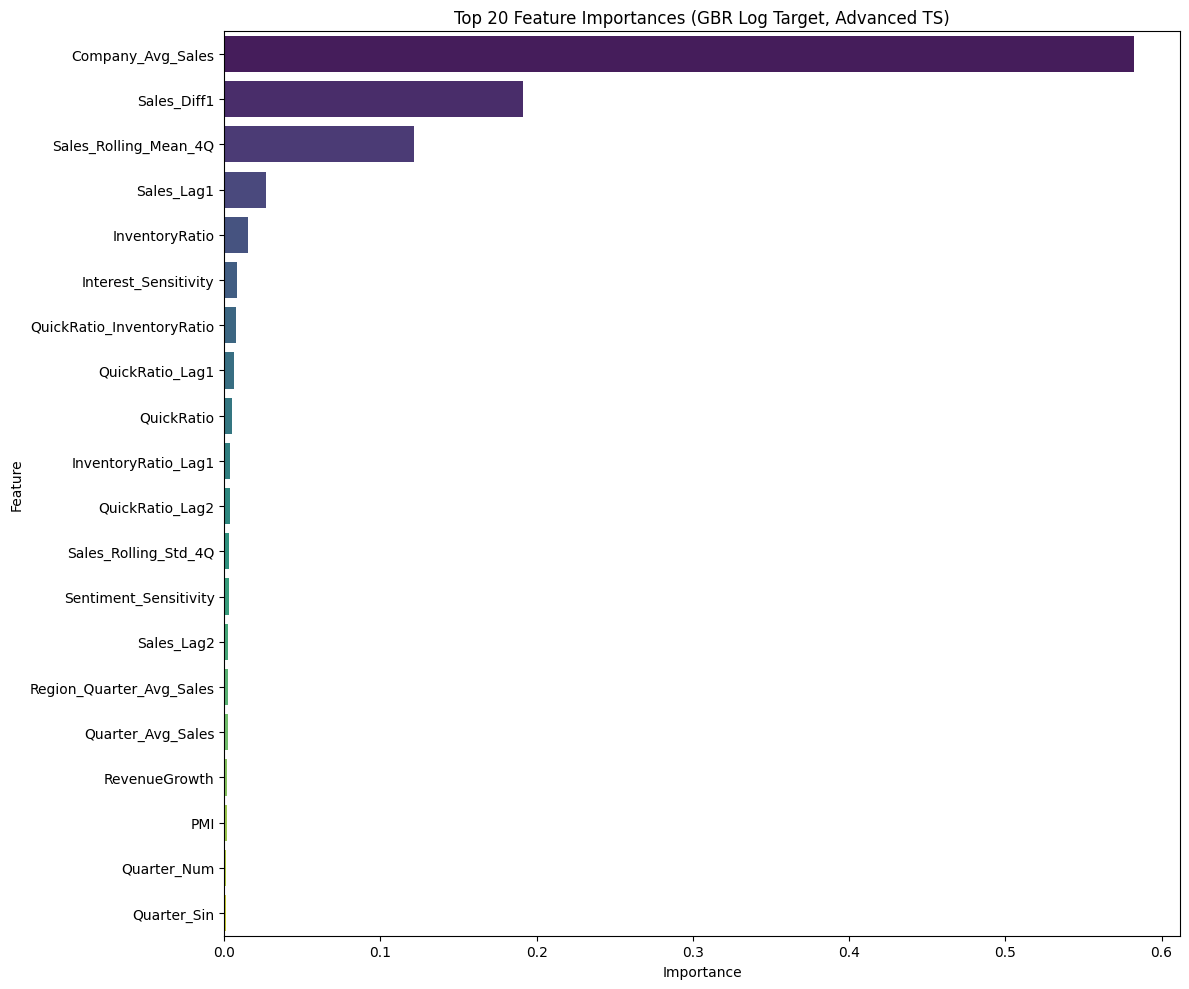


Top 10 Features:
                  Feature  Importance
        Company_Avg_Sales    0.582651
              Sales_Diff1    0.191376
    Sales_Rolling_Mean_4Q    0.121434
               Sales_Lag1    0.026883
           InventoryRatio    0.015474
     Interest_Sensitivity    0.007966
QuickRatio_InventoryRatio    0.007686
          QuickRatio_Lag1    0.006539
               QuickRatio    0.004777
      InventoryRatio_Lag1    0.003769

Generating GBR predictions for test set (log scale)...
Calculating estimated MAE on training data (original scale)...
  Estimated MAE on Training Set (Original Scale): 16.5691
Submission file 'Submission_GBR_LogAdvTS_TrainMAE_17.csv' created successfully.
    RowID        Sales
7       1  1629.684804
8       2  2139.082247
16      3  3990.310424
17      4  3883.089490
25      5  4746.539779

Script finished.


In [3]:
# Cell: 1 - Import Libraries and Set up Environment (Add GroupKFold)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GroupKFold # Added GroupKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error # Added MSE for tuning
import warnings
import os

# TensorFlow / Keras Imports (Keep if needed for comparison, otherwise remove)
# import tensorflow as tf ... etc.
import keras_tuner as kt # Keep if tuner files exist or comparison desired

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
# tf.random.set_seed(SEED) # Only if using TF

# --- Define Helper Functions FIRST ---

# Cell: 2 - Define Data Loading Function (Unchanged)
def load_data():
    # ... (load_data function remains the same) ...
    try:
        train = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/train.csv')
        test = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/test.csv')
        indicators = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/EconomicIndicators.csv')
        print("Data loaded successfully.")
        return train, test, indicators
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Please check input paths.")
        return None, None, None
    except Exception as e:
         print(f"An unexpected error occurred during data loading: {e}")
         return None, None, None

# Cell: 3 - Define Feature Engineering Function (MODIFIED)
def feature_engineering_advanced_ts(train_df, test_df, indicators_df):
    print("\nStarting Advanced Feature Engineering with Time Series Features...")
    if train_df is None or test_df is None or indicators_df is None:
        print("Input dataframes are missing for feature engineering.")
        return None, None

    # == Part 1: Combine, Sort, Basic Prep ==
    print("Combining train/test for TS feature calculation...")
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()
    indicators_df_copy = indicators_df.copy()

    train_df_copy['Source'] = 'train'
    test_df_copy['Source'] = 'test'
    combined_df = pd.concat([train_df_copy, test_df_copy], ignore_index=True, sort=False)

    combined_df['Quarter_Num'] = combined_df['Quarter'].str.extract(r'Q(\d+)').astype(int)
    combined_df = combined_df.sort_values(['Company', 'Quarter_Num']).reset_index(drop=True)
    print(f"Combined shape after sorting: {combined_df.shape}")

    # == Part 2: Enhanced Time Series Feature Creation ==
    print("Creating target lags and differences...")
    lags_to_create = [1, 2, 3, 4]
    features_to_lag = ['Sales', 'InventoryRatio', 'QuickRatio', 'RevenueGrowth'] # Add more features to lag
    lagged_feature_names = []

    for feat in features_to_lag:
         if feat in combined_df.columns:
             for lag in lags_to_create:
                 col_name = f'{feat}_Lag{lag}'
                 combined_df[col_name] = combined_df.groupby('Company')[feat].shift(lag)
                 lagged_feature_names.append(col_name)
                 # print(f"  - Created {col_name}")
         else:
             print(f"  - Warning: Feature '{feat}' not found for lagging.")

    # Difference feature for Sales
    if 'Sales_Lag1' in combined_df.columns:
         combined_df['Sales_Diff1'] = combined_df['Sales'] - combined_df['Sales_Lag1']
         lagged_feature_names.append('Sales_Diff1')
         print("  - Created Sales_Diff1")

    print("Creating rolling window features (mean/std based on past sales)...")
    rolling_feature_names = []
    if 'Sales' in combined_df.columns:
         sales_shifted = combined_df.groupby('Company')['Sales'].shift(1)
         # Rolling Mean (previous 4 quarters)
         combined_df['Sales_Rolling_Mean_4Q'] = sales_shifted.groupby(combined_df['Company']).rolling(window=4, min_periods=1).mean().reset_index(level=0, drop=True)
         rolling_feature_names.append('Sales_Rolling_Mean_4Q')
         # Rolling Std Dev (previous 4 quarters)
         combined_df['Sales_Rolling_Std_4Q'] = sales_shifted.groupby(combined_df['Company']).rolling(window=4, min_periods=2).std().reset_index(level=0, drop=True)
         combined_df['Sales_Rolling_Std_4Q'].fillna(0, inplace=True) # Fill NaN std devs
         rolling_feature_names.append('Sales_Rolling_Std_4Q')
         print("  - Created rolling Sales features (Mean_4Q, Std_4Q)")
    else:
         print(f"  - Warning: 'Sales' column not found, cannot create rolling window features.")

    # Cyclical Quarter features
    combined_df['Quarter_Sin'] = np.sin(2 * np.pi * combined_df['Quarter_Num'] / 4.0)
    combined_df['Quarter_Cos'] = np.cos(2 * np.pi * combined_df['Quarter_Num'] / 4.0)
    print("  - Created cyclical Quarter_Sin/Cos features")


    # == Part 3: Original Feature Engineering Steps (Applied to combined_df) ==
    print("Applying original feature engineering steps...")
    # (Economic Indicators merge - unchanged)
    def month_to_quarter(month): return (month - 1) // 3 + 1
    indicators_df_copy['Quarter_Map'] = indicators_df_copy['Month'].apply(month_to_quarter)
    quarterly_indicators = indicators_df_copy.groupby('Quarter_Map').agg({
            'Consumer Sentiment': 'mean', 'Interest Rate': 'mean', 'PMI': 'mean',
            'Money Supply': 'mean', 'NationalEAI': 'mean', 'EastEAI': 'mean',
            'WestEAI': 'mean', 'SouthEAI': 'mean', 'NorthEAI': 'mean'
        }).reset_index()
    quarterly_indicators['Quarter'] = 'Q' + quarterly_indicators['Quarter_Map'].astype(str)
    combined_df = pd.merge(combined_df, quarterly_indicators.drop(columns=['Quarter_Map']), on='Quarter', how='left')
    print("Merged economic indicators.")

    # (Group Average Sales - unchanged calculation logic)
    if 'Sales' in train_df_copy.columns:
         # Calculate averages ONLY on the original train_df
         company_avg = train_df_copy.groupby('Company')['Sales'].mean().rename('Company_Avg_Sales')
         industry_avg = train_df_copy.groupby('Industry')['Sales'].mean().rename('Industry_Avg_Sales')
         region_avg = train_df_copy.groupby('Region')['Sales'].mean().rename('Region_Avg_Sales')
         quarter_avg = train_df_copy.groupby('Quarter')['Sales'].mean().rename('Quarter_Avg_Sales')
         ind_q_avg = train_df_copy.groupby(['Industry', 'Quarter'])['Sales'].mean().rename('Industry_Quarter_Avg_Sales')
         reg_q_avg = train_df_copy.groupby(['Region', 'Quarter'])['Sales'].mean().rename('Region_Quarter_Avg_Sales')
         # Merge into combined_df
         combined_df = pd.merge(combined_df, company_avg, on='Company', how='left')
         combined_df = pd.merge(combined_df, industry_avg, on='Industry', how='left')
         combined_df = pd.merge(combined_df, region_avg, on='Region', how='left')
         combined_df = pd.merge(combined_df, quarter_avg, on='Quarter', how='left')
         combined_df = pd.merge(combined_df, ind_q_avg, on=['Industry', 'Quarter'], how='left')
         combined_df = pd.merge(combined_df, reg_q_avg, on=['Region', 'Quarter'], how='left')
         print("Added group-based average sales features (from train).")
    else:
        print("Warning: 'Sales' column missing in train data, cannot create group average sales features.")

    # (Interactions, Ratings, Regional EAI, Sensitivity - unchanged logic, added checks)
    # Interactions
    if 'InventoryRatio' in combined_df.columns and 'QuickRatio' in combined_df.columns:
        combined_df['InventoryRatio_imputed_temp'] = combined_df['InventoryRatio'].fillna(combined_df['InventoryRatio'].median())
        combined_df['QuickRatio_InventoryRatio'] = combined_df['QuickRatio'] * combined_df['InventoryRatio_imputed_temp']
        combined_df.drop(columns=['InventoryRatio_imputed_temp'], inplace=True)
    if 'RevenueGrowth' in combined_df.columns and 'Marketshare' in combined_df.columns:
        combined_df['RevenueGrowth_Marketshare'] = combined_df['RevenueGrowth'] * combined_df['Marketshare']
    # Ratings
    if 'Bond rating' in combined_df.columns and 'Stock rating' in combined_df.columns:
         bond_map = {'AAA':7,'AA':6,'A':5,'BBB':4,'BB':3,'B':2,'CCC':1}; stock_map = {'Strong Buy':5,'Buy':4,'Hold':3,'Underperform':2,'Sell':1}
         combined_df['Bond_Rating_Numeric'] = combined_df['Bond rating'].map(bond_map)
         combined_df['Stock_Rating_Numeric'] = combined_df['Stock rating'].map(stock_map)
    # Regional EAI
    eai_cols = ['Region', 'EastEAI', 'WestEAI', 'SouthEAI', 'NorthEAI', 'NationalEAI']
    if all(col in combined_df.columns for col in eai_cols):
         def regional_eai(r): # Define inside or ensure scope
             region = r['Region']; return r.get(f'{region}EAI', r['NationalEAI']) if region in ['East', 'West', 'South', 'North'] else r['NationalEAI']
         combined_df['Regional_EAI'] = combined_df.apply(regional_eai, axis=1)
    # Sensitivity (ensure relevant columns exist)
    sens_cols = ['Company', 'Consumer Sentiment', 'PMI', 'Interest Rate', 'Sales']
    if 'Source' in combined_df.columns and all(col in combined_df.columns for col in sens_cols):
        sens = {}
        train_sens_data = combined_df[combined_df['Source'] == 'train'].copy()
        for comp, grp in train_sens_data.groupby('Company'):
            cs, cp, ci = 0, 0, 0
            if len(grp) >= 3 and grp['Sales'].nunique() > 1:
                valid_cs = grp['Consumer Sentiment'].nunique() > 1 and not grp['Consumer Sentiment'].isnull().all()
                valid_pmi = grp['PMI'].nunique() > 1 and not grp['PMI'].isnull().all()
                valid_ir = grp['Interest Rate'].nunique() > 1 and not grp['Interest Rate'].isnull().all()
                valid_sales = not grp['Sales'].isnull().all()
                if valid_cs and valid_sales: cs = np.nan_to_num(np.corrcoef(grp['Consumer Sentiment'].fillna(0), grp['Sales'].fillna(0))[0,1])
                if valid_pmi and valid_sales: cp = np.nan_to_num(np.corrcoef(grp['PMI'].fillna(0), grp['Sales'].fillna(0))[0,1])
                if valid_ir and valid_sales: ci = np.nan_to_num(np.corrcoef(grp['Interest Rate'].fillna(0), grp['Sales'].fillna(0))[0,1])
            sens[comp] = {'Sentiment_Sensitivity': cs, 'PMI_Sensitivity': cp, 'Interest_Sensitivity': ci}
        combined_df['Sentiment_Sensitivity'] = combined_df['Company'].map(lambda c: sens.get(c, {}).get('Sentiment_Sensitivity', 0))
        combined_df['PMI_Sensitivity'] = combined_df['Company'].map(lambda c: sens.get(c, {}).get('PMI_Sensitivity', 0))
        combined_df['Interest_Sensitivity'] = combined_df['Company'].map(lambda c: sens.get(c, {}).get('Interest_Sensitivity', 0))
        print("Added interactions, ratings, regional EAI, and sensitivity features.")
    else:
        print("Warning: Columns missing for interactions, ratings, EAI, or sensitivity.")


    # == Part 4: Final Split and NaN Handling ==
    if 'Source' not in combined_df.columns:
         print("Error: 'Source' column missing, cannot split back into train/test.")
         return None, None
    train_enriched = combined_df[combined_df['Source'] == 'train'].drop(columns=['Source'])
    test_cols_to_drop = ['Source'] + (['Sales'] if 'Sales' in combined_df.columns else [])
    test_enriched = combined_df[combined_df['Source'] == 'test'].drop(columns=test_cols_to_drop)

    # (NaN Handling for merged features - unchanged logic)
    merge_nan_cols = [col for col in ['Company_Avg_Sales', 'Industry_Avg_Sales', 'Region_Avg_Sales','Quarter_Avg_Sales', 'Industry_Quarter_Avg_Sales','Region_Quarter_Avg_Sales', 'Sentiment_Sensitivity','PMI_Sensitivity', 'Interest_Sensitivity'] if col in train_enriched.columns]
    if merge_nan_cols:
        train_means = train_enriched[merge_nan_cols].mean()
        for col in merge_nan_cols:
            if col in test_enriched.columns and test_enriched[col].isnull().any():
                if col == 'Company_Avg_Sales' and 'Industry_Avg_Sales' in test_enriched.columns:
                     test_enriched[col] = test_enriched[col].fillna(test_enriched['Industry_Avg_Sales'])
                test_enriched[col].fillna(train_means[col], inplace=True)
    print(f"Train shape after FE: {train_enriched.shape}")
    print(f"Test shape after FE: {test_enriched.shape}")
    print("Feature Engineering complete.")
    return train_enriched, test_enriched


# Cell: 4 - Define Data Preparation Function (MODIFIED for Log Transform and New Features)
def prepare_modeling_data_log(train_enriched, test_enriched):
    print("\nPreparing data for modeling (with log transform)...")
    if train_enriched is None or test_enriched is None:
        print("Enriched dataframes are missing.")
        return None, None, None, None, None, None # Added groups return

    # Target variable + Log Transform
    if 'Sales' not in train_enriched.columns:
         print("Error: 'Sales' column missing from enriched training data.")
         return None, None, None, None, None, None
    y = np.log1p(train_enriched['Sales']) # Apply log1p transform
    X = train_enriched.drop(columns=['Sales'])
    # Keep Company for GroupKFold
    groups = X['Company'] if 'Company' in X.columns else None
    if groups is None:
        print("Warning: 'Company' column not found for GroupKFold grouping.")


    # Define features (INCLUDING NEW TS FEATURES + CYCLICAL)
    numerical_features = [
        'QuickRatio', 'InventoryRatio', 'RevenueGrowth', 'Marketshare',
        'Consumer Sentiment', 'Interest Rate', 'PMI', 'Money Supply',
        'NationalEAI', 'EastEAI', 'WestEAI', 'SouthEAI', 'NorthEAI',
        'Company_Avg_Sales', 'Industry_Avg_Sales', 'Region_Avg_Sales',
        'Quarter_Avg_Sales', 'Industry_Quarter_Avg_Sales',
        'Region_Quarter_Avg_Sales', 'QuickRatio_InventoryRatio',
        'RevenueGrowth_Marketshare',
        'Bond_Rating_Numeric', 'Stock_Rating_Numeric',
        'Regional_EAI', 'Sentiment_Sensitivity',
        'PMI_Sensitivity', 'Interest_Sensitivity',
        'Quarter_Num', # Keep for reference, use Sin/Cos instead
        'Quarter_Sin', 'Quarter_Cos', # Cyclical features
        # -- New Lags/Diff/Rolling --
        'Sales_Lag1', 'Sales_Lag2', 'Sales_Lag3', 'Sales_Lag4', 'Sales_Diff1',
        'InventoryRatio_Lag1','InventoryRatio_Lag2','InventoryRatio_Lag3','InventoryRatio_Lag4',
        'QuickRatio_Lag1','QuickRatio_Lag2','QuickRatio_Lag3','QuickRatio_Lag4',
        'RevenueGrowth_Lag1','RevenueGrowth_Lag2','RevenueGrowth_Lag3','RevenueGrowth_Lag4',
        'Sales_Rolling_Mean_4Q', 'Sales_Rolling_Std_4Q'
    ]
    categorical_features = ['Industry', 'Region']

    # Filter to existing features
    numerical_features = [c for c in numerical_features if c in X.columns]
    categorical_features = [c for c in categorical_features if c in X.columns]
    all_features = numerical_features + categorical_features
    print(f"Selected {len(all_features)} features for modeling.")

    # Ensure all selected features exist in X
    missing_in_X = [f for f in all_features if f not in X.columns]
    if missing_in_X: print(f"Error: Features missing in X: {missing_in_X}"); return None, None, None, None, None, None

    X = X[all_features]

    # Prepare X_test
    test_enriched_cols = [c for c in all_features if c in test_enriched.columns]
    missing_in_test = [f for f in all_features if f not in test_enriched_cols]
    if missing_in_test: print(f"Warning: Features missing in test_enriched: {missing_in_test}.")
    X_test = test_enriched[test_enriched_cols]
    X_test = X_test.reindex(columns=X.columns, fill_value=np.nan) # Align columns

    print(f"Shape of X (train features): {X.shape}")
    print(f"Shape of y (train target - log): {y.shape}")
    print(f"Shape of X_test (test features): {X_test.shape}")

    # Create preprocessing pipeline (Unchanged)
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)], remainder='drop')

    print("Preprocessor defined.")
    # Return original test_enriched for RowID and groups for CV
    return X, y, X_test, preprocessor, test_enriched, groups


# === Main Execution Flow ===

# Cell: 5 - Load Data
train, test, indicators = load_data()

# Cell: 6 - Run Feature Engineering
train_enriched, test_enriched = (None, None) # Initialize
if train is not None:
    train_enriched, test_enriched = feature_engineering_advanced_ts(train, test, indicators)

# Cell: 7 - Run Data Preparation
X_train, y_train_log, X_test, preprocessor, test_enriched_final, groups = (None, None, None, None, None, None) # Initialize
if train_enriched is not None:
    X_train, y_train_log, X_test, preprocessor, test_enriched_final, groups = prepare_modeling_data_log(train_enriched, test_enriched)


# Cell: 8 - Gradient Boosting Regressor Tuning and Training (MODIFIED for Log Target, GroupKFold, More Iterations)
def tune_and_train_gbr_log(X_train, y_train_log, groups, preprocessor):
    print("\nTuning and Training GBR on Log-Transformed Target with GroupKFold...")
    if X_train is None or y_train_log is None or preprocessor is None or groups is None:
        print("Input data, preprocessor, or groups missing. Skipping GBR tuning.")
        return None, None, None

    # Define the parameter grid (focus on potentially lower learning rates)
    param_dist = {
        'model__n_estimators': [200, 400, 600, 800, 1000], # More estimators might be needed
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07], # Focus on lower rates
        'model__max_depth': [4, 5, 6, 7], # Deeper trees might capture more interactions
        'model__min_samples_split': [5, 10, 15, 20],
        'model__min_samples_leaf': [3, 5, 7, 10],
        'model__subsample': [0.7, 0.8, 0.9], # Keep stochasticity
        'model__max_features': ['sqrt', 0.7, 0.8, 0.9] # Explore feature subsets
    }

    # Create the full pipeline: Preprocessor -> GBR
    # NOTE: GBR loss is kept as default 'squared_error' which optimizes for MSE on the (log) target
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=SEED))
    ])

    # Set up GroupKFold cross-validation
    n_splits_cv = 5
    cv_strategy = GroupKFold(n_splits=n_splits_cv)

    # Set up RandomizedSearchCV - INCREASED n_iter
    n_iter_search = 150 # Increase iterations
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        cv=cv_strategy,
        scoring='neg_mean_squared_error', # Optimize for MSE on log scale
        n_jobs=-1,
        random_state=SEED,
        verbose=1
    )

    print(f"Starting Randomized Search CV ({n_iter_search} iterations, {n_splits_cv}-Fold GroupKFold)...")
    # Fit using groups
    random_search.fit(X_train, y_train_log, groups=groups)

    print("\nRandomized Search CV complete.")
    best_score_mse = -random_search.best_score_ if hasattr(random_search, 'best_score_') else float('inf')
    print(f"Best MSE score (log scale) from CV: {best_score_mse:.4f}")
    print("Best parameters found:")
    best_params = random_search.best_params_ if hasattr(random_search, 'best_params_') else {}
    for param, value in best_params.items(): print(f"  {param}: {value}")

    best_gbr_pipeline = random_search.best_estimator_ if hasattr(random_search, 'best_estimator_') else None
    if best_gbr_pipeline: print("\nBest GBR pipeline is already refit on the full training data (log scale).")
    else: print("\nCould not retrieve best GBR pipeline from search.")

    return best_gbr_pipeline, best_params, random_search


# Run tuning and training
best_gbr_pipeline_log, best_gbr_params_log, search_results_log = (None, None, None)
if X_train is not None:
    best_gbr_pipeline_log, best_gbr_params_log, search_results_log = tune_and_train_gbr_log(X_train, y_train_log, groups, preprocessor)


# Cell: 9 - Feature Importance Analysis (Unchanged Function, just call it)
def analyze_feature_importance_tuned(pipeline, X_train):
     # (Function definition is the same as before)
     print("\nAnalyzing Feature Importance for the Tuned GBR Model (Advanced TS Features)...")
     if pipeline is None or X_train is None: print("Pipeline or training data missing."); return
     try:
        preprocessor = pipeline.named_steps['preprocessor']
        model = pipeline.named_steps['model']
        num_features_tf = preprocessor.transformers_[0][2]
        cat_transformer = preprocessor.transformers_[1][1]; ohe_step = cat_transformer.named_steps['onehot']; cat_features_original = preprocessor.transformers_[1][2]
        if hasattr(ohe_step, 'get_feature_names_out'): ohe_feature_names = ohe_step.get_feature_names_out(cat_features_original)
        else: ohe_feature_names = ohe_step.get_feature_names(cat_features_original)
        all_feature_names = list(num_features_tf) + list(ohe_feature_names)
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            if len(importances) != len(all_feature_names): print(f"Warning: Mismatch in importance ({len(importances)}) vs feature names ({len(all_feature_names)}). Skipping plot."); return
            fi_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances}).sort_values('Importance', ascending=False).reset_index(drop=True)
            plt.figure(figsize=(12, 10)); sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis'); plt.title('Top 20 Feature Importances (GBR Log Target, Advanced TS)'); plt.tight_layout(); plt.show()
            print("\nTop 10 Features:"); print(fi_df.head(10).to_string(index=False))
        else: print("Model does not have feature_importances_.")
     except Exception as e: print(f"Error during importance analysis: {e}"); import traceback; traceback.print_exc()

if best_gbr_pipeline_log is not None:
    analyze_feature_importance_tuned(best_gbr_pipeline_log, X_train)


# Cell: 10 - Generate Submission File (MODIFIED for Inverse Transform)
def generate_submission_log(pipeline, X_test, test_df_original, filename="submission_gbr_log_adv_ts.csv"):
    print(f"\nGenerating GBR predictions for test set (log scale)...")
    if pipeline is None or X_test is None or test_df_original is None: print("Missing components for submission."); return

    # --- RowID Recovery Logic (same as in NN cell) ---
    row_id_col = None
    if 'RowID' in test_df_original.columns: row_id_col = test_df_original['RowID']
    else:
        print("Warning: 'RowID' missing. Attempting recovery..."); # ... (rest of recovery logic) ...
        try: # Simplified recovery for brevity
             original_test_file = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/test.csv')
             if len(test_df_original) == len(original_test_file): row_id_col = original_test_file['RowID']
             else: row_id_col = test_df_original.index + 1
        except: row_id_col = test_df_original.index + 1 # Fallback
    if row_id_col is None: print("Fatal: Could not get RowID."); return
    # --- End RowID Recovery ---

    try:
        # Predict on the log scale
        test_predictions_log = pipeline.predict(X_test)
        # Inverse transform using expm1
        test_predictions_final = np.expm1(test_predictions_log)
        # Ensure non-negative
        test_predictions_final = np.maximum(0, test_predictions_final)

        submission_df = pd.DataFrame({'RowID': row_id_col, 'Sales': test_predictions_final})
        submission_df['RowID'] = submission_df['RowID'].astype(int)

        # --- Calculate Estimated MAE on Original Scale (Optional but useful) ---
        # This requires predicting on the training set and comparing
        if X_train is not None and 'Sales' in train_enriched.columns: # Need original sales
             print("Calculating estimated MAE on training data (original scale)...")
             train_preds_log = pipeline.predict(X_train)
             train_preds_final = np.expm1(train_preds_log)
             train_mae_orig_scale = mean_absolute_error(train_enriched['Sales'], train_preds_final)
             print(f"  Estimated MAE on Training Set (Original Scale): {train_mae_orig_scale:.4f}")
             # Add this to filename for reference
             filename = filename.replace(".csv", f"_TrainMAE_{train_mae_orig_scale:.0f}.csv")
        # --- End MAE Estimation ---


        submission_df.to_csv(filename, index=False)
        print(f"Submission file '{filename}' created successfully.")
        print(submission_df.head())

    except Exception as e:
        print(f"An error occurred during submission generation: {e}")
        import traceback; traceback.print_exc()


# Generate submission
if best_gbr_pipeline_log is not None and X_test is not None and test_enriched_final is not None:
    generate_submission_log(best_gbr_pipeline_log, X_test, test_enriched_final, filename="Submission_GBR_LogAdvTS.csv")
else:
    print("Skipping GBR submission generation.")


print("\nScript finished.")

In [4]:
# -*- coding: utf-8 -*-
"""
Advanced Sales Forecasting Script - Corrected ValueError Attempt 3 (Full Script)
"""

# Cell: 1 - Import Libraries and Set up Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    StackingRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgbm
import xgboost as xgb
import optuna
import warnings
import os
import sys

warnings.filterwarnings('ignore')
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# --- Define Helper Functions FIRST ---

# Cell: 2 - Define Data Loading Function
def load_data():
    """Loads train, test, and indicator data from specified paths."""
    try:
        base_path = '/kaggle/input/sp-25-sales-forecasting/'
        train = pd.read_csv(os.path.join(base_path, 'train.csv'))
        test = pd.read_csv(os.path.join(base_path, 'test.csv'))
        indicators = pd.read_csv(os.path.join(base_path, 'EconomicIndicators.csv'))
        print("Data loaded successfully.")
        print("Input files found:")
        for dirname, _, filenames in os.walk(base_path):
            for filename in filenames: print(os.path.join(dirname, filename))
        return train, test, indicators
    except FileNotFoundError as e:
        print(f"Error loading data: {e}\nPlease ensure files are in: {base_path}")
        return None, None, None
    except Exception as e:
         print(f"An unexpected error occurred during data loading: {e}")
         return None, None, None

# Cell: 3 - Define Enhanced Feature Engineering Function
def advanced_feature_engineering(train, test, indicators):
    """Performs advanced feature engineering including interactions, lags, ratings, etc."""
    print("\nStarting Enhanced Feature Engineering...")
    train_df, test_df, indicators_df = train.copy(), test.copy(), indicators.copy()

    # 1) Convert Month -> quarter
    def month_to_quarter(month): return (month - 1) // 3 + 1
    indicators_df['Quarter'] = indicators_df['Month'].apply(month_to_quarter)

    # 2) Aggregate indicators
    quarterly_indicators = indicators_df.groupby('Quarter').agg({
            'Consumer Sentiment': ['mean', 'min', 'max', 'std'], 'Interest Rate': ['mean', 'min', 'max', 'std'],
            'PMI': ['mean', 'min', 'max', 'std'], 'Money Supply': ['mean', 'min', 'max', 'std'],
            'NationalEAI': ['mean', 'min', 'max', 'std'], 'EastEAI': ['mean', 'min', 'max', 'std'],
            'WestEAI': ['mean', 'min', 'max', 'std'], 'SouthEAI': ['mean', 'min', 'max', 'std'],
            'NorthEAI': ['mean', 'min', 'max', 'std']}).fillna(0) # Fill NaNs in aggregates
    quarterly_indicators.columns = ['_'.join(col).strip('_') for col in quarterly_indicators.columns.values]
    quarterly_indicators.reset_index(inplace=True)
    quarterly_indicators['Quarter'] = 'Q' + quarterly_indicators['Quarter'].astype(str)

    # 4) Merge indicators
    train_enriched = pd.merge(train_df, quarterly_indicators, on='Quarter', how='left')
    test_enriched  = pd.merge(test_df,  quarterly_indicators, on='Quarter', how='left')
    print(f"Train shape after merging indicators: {train_enriched.shape}")
    print(f"Test shape after merging indicators: {test_enriched.shape}")

    # 5) Group stats
    def add_group_stats(df_out, df_in_train, by, prefix):
        if 'Sales' not in df_in_train.columns: return df_out
        stats = df_in_train.groupby(by)['Sales'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
        stats.columns = [by] + [f"{prefix}_{stat}" for stat in ['mean', 'median', 'std', 'min', 'max']]
        std_col = f"{prefix}_std";
        if std_col in stats.columns: stats[std_col] = stats[std_col].fillna(0) # Fill NaN std dev
        return pd.merge(df_out, stats, on=by, how='left')
    for group, prefix in [('Company', 'Company'), ('Industry', 'Industry'), ('Region', 'Region'), ('Quarter', 'Quarter')]:
        train_enriched = add_group_stats(train_enriched, train_df, group, prefix)
        test_enriched = add_group_stats(test_enriched, train_df, group, prefix)

    # 6) Multi-level aggregations
    if 'Sales' in train_df.columns:
        stats_to_merge = []
        ind_q_stats = train_df.groupby(['Industry','Quarter'])['Sales'].agg(['mean', 'median', 'std']).reset_index(); ind_q_stats.columns = ['Industry', 'Quarter'] + [f"Industry_Quarter_{stat}" for stat in ['mean', 'median', 'std']];
        if 'Industry_Quarter_std' in ind_q_stats.columns: ind_q_stats['Industry_Quarter_std'] = ind_q_stats['Industry_Quarter_std'].fillna(0); stats_to_merge.append(ind_q_stats)
        reg_q_stats = train_df.groupby(['Region','Quarter'])['Sales'].agg(['mean', 'median', 'std']).reset_index(); reg_q_stats.columns = ['Region', 'Quarter'] + [f"Region_Quarter_{stat}" for stat in ['mean', 'median', 'std']];
        if 'Region_Quarter_std' in reg_q_stats.columns: reg_q_stats['Region_Quarter_std'] = reg_q_stats['Region_Quarter_std'].fillna(0); stats_to_merge.append(reg_q_stats)
        for stats_df in stats_to_merge:
            train_enriched = pd.merge(train_enriched, stats_df, on=list(stats_df.columns[:2]), how='left'); test_enriched = pd.merge(test_enriched, stats_df, on=list(stats_df.columns[:2]), how='left')
        print("Added multi-level group statistics.")
    else: print("Warning: 'Sales' missing, skipping multi-level group stats.")

    # 7) Interaction features
    for df in [train_enriched, test_enriched]:
        if 'InventoryRatio' in df.columns:
             df['InventoryRatio_imputed_temp'] = df['InventoryRatio'].fillna(df['InventoryRatio'].median())
             if 'QuickRatio' in df.columns: df['QuickRatio_InventoryRatio'] = df['QuickRatio'] * df['InventoryRatio_imputed_temp']
             if 'Marketshare' in df.columns: df['Inventory_Market_Ratio'] = df['InventoryRatio_imputed_temp'] / (df['Marketshare'].replace(0, 0.001) + 0.001)
             if 'RevenueGrowth' in df.columns: df['Growth_Inventory_Ratio'] = df['RevenueGrowth'] / (df['InventoryRatio_imputed_temp'].replace(0, 0.001) + 0.001)
             df.drop(columns=['InventoryRatio_imputed_temp'], inplace=True, errors='ignore')
        if 'RevenueGrowth' in df.columns and 'Marketshare' in df.columns: df['RevenueGrowth_Marketshare'] = df['RevenueGrowth'] * df['Marketshare']
        base_indicator_cols = ['Interest Rate_mean', 'Consumer Sentiment_mean', 'PMI_mean']
        if all(col in df.columns for col in base_indicator_cols):
             if 'QuickRatio' in df.columns: df['QuickRatio_InterestRate'] = df['QuickRatio'] * df['Interest Rate_mean']
             if 'RevenueGrowth' in df.columns: df['RevenueGrowth_ConsumerSentiment'] = df['RevenueGrowth'] * df['Consumer Sentiment_mean']
             if 'Marketshare' in df.columns: df['Marketshare_PMI'] = df['Marketshare'] * df['PMI_mean']
             df['Econ_Composite'] = (df['Consumer Sentiment_mean'] * 0.3 + df['PMI_mean'] * 0.4 - df['Interest Rate_mean'] * 0.3)

    # 8) Ratings
    if 'Bond rating' in train_enriched.columns and 'Stock rating' in train_enriched.columns:
         bond_map={'AAA':7,'AA':6,'A':5,'BBB':4,'BB':3,'B':2,'CCC':1}; stock_map={'Strong Buy':5,'Buy':4,'Hold':3,'Underperform':2,'Sell':1}
         bond_median=np.median(list(bond_map.values())); stock_median=np.median(list(stock_map.values()))
         for df in [train_enriched, test_enriched]:
             df['Bond_Rating_Numeric']=df['Bond rating'].map(bond_map).fillna(bond_median); df['Stock_Rating_Numeric']=df['Stock rating'].map(stock_map).fillna(stock_median)
             df['Combined_Rating']=df['Bond_Rating_Numeric'] * df['Stock_Rating_Numeric']; df['Rating_Divergence']=(df['Bond_Rating_Numeric'] / 7) - (df['Stock_Rating_Numeric'] / 5)
         print("Added advanced interaction and rating features.")
    else: print("Warning: Rating columns missing.")

    # 9) Regional EAI
    eai_cols = ['Region', 'EastEAI_mean', 'WestEAI_mean', 'SouthEAI_mean', 'NorthEAI_mean', 'NationalEAI_mean']
    if all(col in train_enriched.columns for col in eai_cols):
         def regional_eai_all(r):
             region=r.get('Region'); national=r.get('NationalEAI_mean', 0); regional=r.get(f'{region}EAI_mean', national) if region in ['East','West','South','North'] else national
             diff=regional-national; relative=regional/(national+0.001) if national!=-0.001 else regional/0.001
             return pd.Series({'Regional_EAI':regional, 'Regional_National_EAI_Diff':diff, 'Regional_EAI_Relative':relative})
         for df in [train_enriched, test_enriched]:
             eai_features = df.apply(regional_eai_all, axis=1); df[['Regional_EAI','Regional_National_EAI_Diff','Regional_EAI_Relative']] = eai_features
             for region in ['East','West','North','South']: df[f'{region}_Region_Flag']=(df['Region']==region).astype(int)
             for metric in ['Consumer Sentiment_mean','PMI_mean','Interest Rate_mean']:
                 if metric in df.columns: df[f'{region}_{metric}']=df[f'{region}_Region_Flag']*df[metric]
    else: print("Warning: EAI mean cols missing.")

    # 10) Sensitivity & Positioning
    sensitivity_metrics, positioning_metrics = {}, {}
    sens_calc_cols = ['Company','Consumer Sentiment_mean','PMI_mean','Interest Rate_mean','Money Supply_mean','NationalEAI_mean','Regional_EAI','Sales','Industry','Marketshare','Stock_Rating_Numeric']
    if all(col in train_enriched.columns for col in sens_calc_cols):
        for company, grp in train_enriched.groupby('Company'):
            sens_metrics, pos_metrics = {}, {};
            if len(grp)>=3 and grp['Sales'].nunique()>1:
                clean_sales = grp['Sales'].fillna(0)
                for metric in ['Consumer Sentiment_mean','PMI_mean','Interest Rate_mean','Money Supply_mean','NationalEAI_mean','Regional_EAI']:
                    if metric in grp.columns and grp[metric].nunique()>1: clean_metric = grp[metric].fillna(0); corr = np.corrcoef(clean_metric, clean_sales)[0,1] if len(clean_metric)==len(clean_sales) else 0; sens_metrics[f'{metric}_Sensitivity'] = np.nan_to_num(corr)
                    else: sens_metrics[f'{metric}_Sensitivity'] = 0
                industry_mean=train_df[train_df['Industry']==grp['Industry'].iloc[0]]['Sales'].mean(); mean_sales=grp['Sales'].mean()
                pos_metrics = {'IndustryPosition': mean_sales/(industry_mean+0.001) if industry_mean else 1, 'MarketShareToSalesRatio': grp['Marketshare'].mean()/(mean_sales/10000+0.001), 'RatingEffectiveness': grp['Stock_Rating_Numeric'].mean()*(mean_sales/5000)}
            else:
                 for metric in ['Consumer Sentiment_mean','PMI_mean','Interest Rate_mean','Money Supply_mean','NationalEAI_mean','Regional_EAI']: sens_metrics[f'{metric}_Sensitivity'] = 0
                 pos_metrics = {'IndustryPosition': 1, 'MarketShareToSalesRatio': 0, 'RatingEffectiveness': 0}
            sensitivity_metrics[company], positioning_metrics[company] = sens_metrics, pos_metrics
        for df in [train_enriched, test_enriched]:
            for metric in ['Consumer Sentiment_mean','PMI_mean','Interest Rate_mean','Money Supply_mean','NationalEAI_mean','Regional_EAI']: df[f'{metric}_Sensitivity']=df['Company'].map(lambda c: sensitivity_metrics.get(c, {}).get(f'{metric}_Sensitivity', 0))
            for metric in ['IndustryPosition','MarketShareToSalesRatio','RatingEffectiveness']: df[metric]=df['Company'].map(lambda c: positioning_metrics.get(c, {}).get(metric, 1 if metric=='IndustryPosition' else 0))
        print("Added advanced economic sensitivity and market positioning features.")
    else: print("Warning: Cols missing for sensitivity/positioning calc.")

    # 11) Quarter features
    for df in [train_enriched, test_enriched]:
        if 'Quarter' in df.columns:
             df['Quarter_Numeric']=df['Quarter'].str.extract(r'Q(\d+)').astype(int); df['Quarter_Sin']=np.sin(2*np.pi*df['Quarter_Numeric']/4); df['Quarter_Cos']=np.cos(2*np.pi*df['Quarter_Numeric']/4); df['Quarter_Trend']=df['Quarter_Numeric']-2.5

    # 12) Fill NaNs (CORRECTED LOGIC - Nesting Fix)
    original_cols = set(train.columns)|set(test.columns)
    numeric_cols_to_fill = [col for col in train_enriched.select_dtypes(include=np.number).columns if col not in original_cols or col in ['InventoryRatio']]
    if numeric_cols_to_fill:
        train_means = train_enriched[numeric_cols_to_fill].mean()
        train_medians = train_enriched[numeric_cols_to_fill].median()
        print(f"Attempting to fill NaNs in {len(numeric_cols_to_fill)} potential columns in test set...")
        for col in numeric_cols_to_fill:
            if col in test_enriched.columns and test_enriched[col].isnull().any():
                fill_value = train_medians.get(col, 0) if ('Ratio' in col or 'Rating' in col or '_std' in col or 'Divergence' in col or 'Position' in col or 'Sensitivity' in col) else train_means.get(col, 0)
                # *** CORRECTED NESTING ***
                if col.startswith('Company_'):
                    ind_col = col.replace('Company_', 'Industry_')
                    reg_col = col.replace('Company_', 'Region_')
                    # Try filling with Industry column if it exists
                    if ind_col in test_enriched.columns:
                        test_enriched[col] = test_enriched[col].fillna(test_enriched[ind_col])
                    # Try filling *remaining* NaNs with Region column if it exists
                    if reg_col in test_enriched.columns:
                        test_enriched[col] = test_enriched[col].fillna(test_enriched[reg_col])
                # Fill any remaining NaNs with the global train mean/median
                test_enriched[col].fillna(fill_value, inplace=True)
        print("NaN filling in test set complete.")
    else: print("No derived numeric columns identified for NaN filling.")

    print(f"Train shape after advanced FE: {train_enriched.shape}"); print(f"Test shape after advanced FE: {test_enriched.shape}")
    print("Enhanced Feature Engineering complete.")
    return train_enriched, test_enriched


# Cell: 4 - Define Advanced Data Preparation Function (CORRECTED Preprocessor & DEBUG)
def prepare_advanced_modeling_data(train_enriched, test_enriched):
    """Prepares data, fits preprocessor, configures selector."""
    print("\nPreparing data with advanced feature processing...")
    if train_enriched is None or test_enriched is None: return None, None, None, None, None, None, None, None

    # Handle infinite values
    numeric_cols_all = train_enriched.select_dtypes(include=np.number).columns
    for df in [train_enriched, test_enriched]:
        for col in numeric_cols_all:
             if col in df.columns:
                 df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                 # Use train median to fill NaNs created from inf
                 df[col].fillna(train_enriched[col].median(), inplace=True)

    # Outlier Handling
    if 'Sales' not in train_enriched.columns: return None, None, None, None, None, None, None, None
    Q1=train_enriched['Sales'].quantile(0.25); Q3=train_enriched['Sales'].quantile(0.75); IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR; upper_bound=Q3+1.5*IQR
    train_enriched['is_outlier']=((train_enriched['Sales']<lower_bound)|(train_enriched['Sales']>upper_bound)).astype(int)
    train_enriched['sample_weight']=1.0; train_enriched.loc[train_enriched['is_outlier']==1, 'sample_weight']=0.5
    y=train_enriched['Sales']; sample_weights=train_enriched['sample_weight']

    # Define features
    non_feature_cols=['Sales','RowID','is_outlier','sample_weight','Bond rating','Stock rating','Quarter','Quarter_Numeric']
    categorical_cols=['Industry','Region','Company']; categorical_cols=[col for col in categorical_cols if col in train_enriched.columns]
    feature_cols=[col for col in train_enriched.columns if col not in non_feature_cols]; numerical_cols=[col for col in feature_cols if col not in categorical_cols]; feature_cols=numerical_cols+categorical_cols
    if not feature_cols: print("Error: No features."); return None,None,None,None,None,None,None,None

    print(f"Using {len(numerical_cols)} numerical features."); print(f"Using {len(categorical_cols)} categorical features.")

    # Feature DataFrames
    X = train_enriched[feature_cols]
    for col in feature_cols:
        if col not in test_enriched.columns: test_enriched[col]=np.nan # Add missing columns before reindex
    X_test = test_enriched[feature_cols]; X_test = X_test.reindex(columns=X.columns, fill_value=np.nan)
    print(f"Shape of X: {X.shape}"); print(f"Shape of y: {y.shape}"); print(f"Shape of X_test: {X_test.shape}")

    # Preprocessing Pipeline Definition
    numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler())])
    # *** CORRECTION: Removed min_frequency from OneHotEncoder ***
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
    # *** CORRECTION: Changed remainder to 'drop' ***
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_cols), ('cat', categorical_transformer, categorical_cols)], remainder='drop')

    # --- Fit Preprocessor & Configure Selector ---
    print("Performing Feature Selection...")
    try:
        # Fit preprocessor ONCE on full training data X
        print(f"DEBUG: Fitting preprocessor on X with shape {X.shape}")
        preprocessor.fit(X, y) # Fit here!
        X_processed_fs = preprocessor.transform(X) # Transform full X
        print(f"DEBUG: Shape after preprocessor.transform(X): {X_processed_fs.shape}") # DEBUG PRINT
        y_fs = y

        if X_processed_fs.shape[1] == 0: print("ERROR: Preprocessor output zero features."); return None, None, None, None, None, None, None, None

        feature_names_out = preprocessor.get_feature_names_out()
        print(f"Total features after preprocessing: {len(feature_names_out)}")

    except Exception as e: print(f"Error during preprocessing fit/transform: {e}"); return None, None, None, None, None, None, None, None

    # Fit selector model
    selector_model_fs = lgbm.LGBMRegressor(random_state=SEED, n_estimators=100, learning_rate=0.1, verbose=-1)
    selector_model_fs.fit(X_processed_fs, y_fs, sample_weight=sample_weights)

    # Configure the selector object using the fitted model
    selector = SelectFromModel(selector_model_fs, threshold='median', prefit=True) # prefit=True!

    # Check selected features
    selected_mask = selector.get_support(); num_selected = selected_mask.sum()
    print(f"Selected {num_selected} features out of {len(feature_names_out)} after preprocessing.")
    if num_selected > 0:
        selected_feature_names = feature_names_out[selected_mask]
        print("Example selected features:", list(selected_feature_names[:min(10, len(selected_feature_names))]))
    else: print("WARNING: No features selected."); selected_feature_names = []

    print("Advanced data preparation complete.")
    # Return the FITTED preprocessor and the CONFIGURED selector object
    return (X, y, X_test, preprocessor, selector, test_enriched, sample_weights, selected_feature_names)


# Cell: 5 - Define Advanced Ensemble Model Building Function (Uses fitted objects, Added DEBUG)
def build_advanced_ensemble(X, y, preprocessor, selector, sample_weights):
    """Builds and trains the initial stacking ensemble pipeline."""
    print("\nBuilding advanced ensemble model...")
    if X is None or y is None or preprocessor is None or selector is None: return None, None

    X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(X, y, sample_weights, test_size=0.2, random_state=SEED)

    # Base models
    lgb_model = lgbm.LGBMRegressor(random_state=SEED, n_estimators=300, learning_rate=0.05, num_leaves=31, subsample=0.8, colsample_bytree=0.8, verbose=-1)
    xgb_model = xgb.XGBRegressor(random_state=SEED, n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror')
    gbr_model = GradientBoostingRegressor(random_state=SEED, n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, min_samples_leaf=5)
    et_model = ExtraTreesRegressor(random_state=SEED, n_estimators=200, max_depth=12, min_samples_split=10, min_samples_leaf=5, n_jobs=-1)
    meta_learner = Ridge(alpha=1.0)
    stack_ensemble = StackingRegressor(estimators=[('lgb',lgb_model), ('xgb',xgb_model), ('gbr',gbr_model), ('et',et_model)], final_estimator=meta_learner, cv=5, n_jobs=-1, passthrough=False)

    # FINAL Pipeline uses PASSED FITTED/CONFIGURED objects
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor), # Uses the FITTED preprocessor
        ('selector', selector),         # Uses the CONFIGURED selector
        ('model', stack_ensemble)
    ])

    # Train the *entire* pipeline on the training split
    print("Training ensemble pipeline on training split...")
    try:
        # === DEBUG BLOCK ===
        print(f"DEBUG: X_train shape before pipeline.fit: {X_train.shape}")
        temp_processed = preprocessor.transform(X_train) # Use transform() not fit_transform()
        print(f"DEBUG: Shape after preprocessor.transform(X_train) inside build_advanced_ensemble: {temp_processed.shape}")
        temp_selected = selector.transform(temp_processed)
        print(f"DEBUG: Shape after selector.transform(...) inside build_advanced_ensemble: {temp_selected.shape}")
        # === END DEBUG BLOCK ===

        final_pipeline.fit(X_train, y_train) # Fit pipeline (no explicit weights needed for stacking fit)
    except ValueError as ve:
        print(f"*** Caught ValueError during pipeline.fit: {ve} ***")
        print("This likely means the number of features output by a step differs from what the next step expects.")
        # Try to get expected features if possible
        try:
            if hasattr(selector, 'n_features_in_'): # Check selector
                 print(f"Selector expected features: {selector.n_features_in_}")
            elif hasattr(selector, 'estimator_') and hasattr(selector.estimator_, 'n_features_in_'): # Check underlying estimator
                 print(f"Selector's underlying model expected features: {selector.estimator_.n_features_in_}")

            # Check preprocessor output features again JUST before error
            processed_debug = preprocessor.transform(X_train)
            print(f"Features provided to selector was: {processed_debug.shape[1]}")
        except Exception as debug_e:
             print(f"Error getting debug info: {debug_e}")
        return None, None # Exit if fit fails
    except Exception as e: print(f"Error fitting initial ensemble pipeline: {e}"); return None, None

    # Evaluate on validation set
    try:
        val_pred = final_pipeline.predict(X_val); val_mae = mean_absolute_error(y_val, val_pred)
        print(f"Validation MAE on initial ensemble: {val_mae:.2f}")
    except Exception as e: print(f"Error during validation prediction: {e}"); val_mae = float('inf')

    # Re-train final model on ALL data
    print("Re-training ensemble pipeline on full dataset...")
    try:
        final_pipeline.fit(X, y) # Fit on full data
    except Exception as e: print(f"Error fitting final pipeline on full data: {e}"); return None, val_mae # Keep MAE if calculated

    print("Ensemble model training complete.")
    return final_pipeline, val_mae


# Cell: 6 - Define Hyperparameter Optimization Function (Optuna) (Uses fitted objects)
def optimize_hyperparameters(X, y, preprocessor, selector, sample_weights):
    """Optimizes hyperparameters for the stacking ensemble using Optuna."""
    print("\nOptimizing hyperparameters with Optuna...")
    if X is None or y is None or preprocessor is None or selector is None: return None

    X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(X, y, sample_weights, test_size=0.2, random_state=SEED)

    # Preprocess and select features ONCE
    print("Preprocessing and selecting features for Optuna objective...")
    try:
        # Use the FITTED preprocessor and CONFIGURED selector passed in
        X_train_processed = preprocessor.transform(X_train); X_val_processed = preprocessor.transform(X_val)
        print(f"DEBUG: Shape after preprocessor.transform(X_train) in Optuna setup: {X_train_processed.shape}") # DEBUG
        X_train_selected = selector.transform(X_train_processed); X_val_selected = selector.transform(X_val_processed)
        print(f"Shape after selection for Optuna: Train={X_train_selected.shape}, Val={X_val_selected.shape}")
    except ValueError as ve: print(f"ValueError during preprocessing/selection for Optuna: {ve}"); return None
    except Exception as e: print(f"Error during preprocessing/selection for Optuna: {e}"); return None

    # Define Optuna objective function
    def objective(trial):
        lgb_params = { 'n_estimators': trial.suggest_int('lgb_n_estimators', 200, 800, step=50), 'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.1, log=True), 'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 60), 'subsample': trial.suggest_float('lgb_subsample', 0.6, 0.9), 'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.6, 0.9), 'reg_alpha': trial.suggest_float('lgb_reg_alpha', 1e-3, 1.0, log=True), 'reg_lambda': trial.suggest_float('lgb_reg_lambda', 1e-3, 1.0, log=True), 'min_child_samples': trial.suggest_int('lgb_min_child_samples', 5, 30), 'verbose': -1, 'random_state': SEED }
        xgb_params = { 'n_estimators': trial.suggest_int('xgb_n_estimators', 200, 800, step=50), 'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.1, log=True), 'max_depth': trial.suggest_int('xgb_max_depth', 3, 8), 'subsample': trial.suggest_float('xgb_subsample', 0.6, 0.9), 'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 0.9), 'reg_alpha': trial.suggest_float('xgb_reg_alpha', 1e-3, 1.0, log=True), 'reg_lambda': trial.suggest_float('xgb_reg_lambda', 1e-3, 1.0, log=True), 'gamma': trial.suggest_float('xgb_gamma', 0, 0.5), 'random_state': SEED, 'objective': 'reg:squarederror' }
        gbr_params = { 'n_estimators': trial.suggest_int('gbr_n_estimators', 200, 800, step=50), 'learning_rate': trial.suggest_float('gbr_learning_rate', 0.01, 0.1, log=True), 'max_depth': trial.suggest_int('gbr_max_depth', 3, 8), 'subsample': trial.suggest_float('gbr_subsample', 0.6, 0.9), 'min_samples_leaf': trial.suggest_int('gbr_min_samples_leaf', 3, 10), 'min_samples_split': trial.suggest_int('gbr_min_samples_split', 5, 20), 'random_state': SEED }
        meta_alpha = trial.suggest_float('meta_alpha', 0.1, 10.0, log=True)
        lgb_model=lgbm.LGBMRegressor(**lgb_params); xgb_model=xgb.XGBRegressor(**xgb_params); gbr_model=GradientBoostingRegressor(**gbr_params); meta_learner=Ridge(alpha=meta_alpha)
        stack = StackingRegressor(estimators=[('lgb',lgb_model), ('xgb',xgb_model), ('gbr',gbr_model)], final_estimator=meta_learner, cv=3, n_jobs=-1, passthrough=False)
        # Fit on *preprocessed and selected* data
        stack.fit(X_train_selected, y_train) # Fit without weights for optuna speed
        val_pred = stack.predict(X_val_selected)
        mae = mean_absolute_error(y_val, val_pred)
        return mae

    # Run Optuna study
    study = optuna.create_study(direction='minimize', study_name='sales_stacking_opt_v4')
    try:
        study.optimize(objective, n_trials=50, show_progress_bar=True) # Adjust n_trials
        best_params = study.best_params; best_mae = study.best_value
        print(f"\nBest Optuna optimization value (MAE): {best_mae:.2f}")
    except Exception as e: print(f"Error during Optuna optimization: {e}"); return None

    # Create final optimized models
    lgb_best=lgbm.LGBMRegressor(**{k.replace('lgb_',''):v for k,v in best_params.items() if k.startswith('lgb_')}, random_state=SEED, verbose=-1)
    xgb_best=xgb.XGBRegressor(**{k.replace('xgb_',''):v for k,v in best_params.items() if k.startswith('xgb_')}, random_state=SEED, objective='reg:squarederror')
    gbr_best=GradientBoostingRegressor(**{k.replace('gbr_',''):v for k,v in best_params.items() if k.startswith('gbr_')}, random_state=SEED)
    meta_best=Ridge(alpha=best_params.get('meta_alpha', 1.0))
    optimized_stack=StackingRegressor(estimators=[('lgb',lgb_best),('xgb',xgb_best),('gbr',gbr_best)], final_estimator=meta_best, cv=5, n_jobs=-1, passthrough=False)

    # Create the full final pipeline using the *original fitted/configured preprocessor & selector*
    optimized_pipeline = Pipeline([('preprocessor', preprocessor), ('selector', selector), ('model', optimized_stack)])

    # Train final optimized pipeline on ALL data
    print("Training final optimized pipeline on full dataset...")
    try:
        optimized_pipeline.fit(X, y) # Fit without weights for simplicity
    except Exception as e: print(f"Error fitting final optimized pipeline: {e}"); return None

    print("Optimized model training complete.")
    # Store best MAE from study for reference
    optimized_pipeline.best_mae_ = best_mae
    return optimized_pipeline


# Cell: 7 - Define Model Evaluation and Submission Generation Function (Unchanged)
def evaluate_and_submit(pipeline, X_test, test_enriched, filename="submission_advanced_ensemble.csv"):
    """Generates predictions and saves the submission file."""
    print("\nGenerating predictions and submission file...")
    if pipeline is None or X_test is None or test_enriched is None: print("Missing components."); return

    # --- RowID Recovery Logic ---
    row_id_col = None
    if 'RowID' in test_enriched.columns: row_id_col = test_enriched['RowID']
    else:
        print("Warning: 'RowID' missing. Attempting recovery...");
        try:
            original_test_file = pd.read_csv('/kaggle/input/sp-25-sales-forecasting/test.csv')
            if len(test_enriched) == len(original_test_file) and 'Quarter' in test_enriched.columns and 'Company' in test_enriched.columns:
                 temp_df = pd.merge(test_enriched.reset_index(), original_test_file[['Quarter', 'Company', 'RowID']], on=['Quarter', 'Company'], how='left').sort_values('index')
                 if 'RowID' in temp_df.columns and not temp_df['RowID'].isnull().any(): row_id_col = temp_df['RowID']; print("Recovered RowID via merge.")
            if row_id_col is None: print("Generating RowID from index."); row_id_col = test_enriched.index + 1 # Check if RowID starts at 1
        except Exception as e: print(f"Error recovering RowID: {e}. Generating from index."); row_id_col = test_enriched.index + 1
    if row_id_col is None or len(row_id_col) != len(X_test): print(f"Fatal: Invalid RowID column. Aborted."); return
    # --- End RowID Recovery ---

    try:
        test_predictions = pipeline.predict(X_test); test_predictions = np.maximum(0, test_predictions)
        submission_df = pd.DataFrame({'RowID': row_id_col,'Sales': test_predictions}); submission_df['RowID'] = submission_df['RowID'].astype(int)
        submission_df.to_csv(filename, index=False); print(f"Submission file saved as '{filename}'"); print("Submission preview:"); print(submission_df.head())
        print(f"\nSubmission stats:"); print(f"Count: {len(submission_df)}, Min: {submission_df['Sales'].min():.2f}, Max: {submission_df['Sales'].max():.2f}, Mean: {submission_df['Sales'].mean():.2f}, Median: {submission_df['Sales'].median():.2f}")
    except Exception as e: print(f"Error during prediction/submission: {e}"); import traceback; traceback.print_exc()


# Cell: 8 - Define Main Execution Pipeline Function (Passes fitted objects)
def main(train_df, test_df, indicators_df):
    """Main pipeline orchestrating FE, Prep, Modeling, and Submission."""
    if train_df is None or test_df is None or indicators_df is None: print("No valid dataframes passed to main. Exiting."); return
    print("\n=== Starting Advanced Sales Forecasting Pipeline ===")

    # Step 1: Feature Engineering
    train_enriched, test_enriched = advanced_feature_engineering(train_df, test_df, indicators_df)

    # Step 2: Data Preparation (Gets FITTED Preprocessor & CONFIGURED Selector)
    prep_results = prepare_advanced_modeling_data(train_enriched, test_enriched)
    if prep_results is None: print("Data preparation failed. Exiting."); return
    (X, y, X_test, preprocessor, selector, test_enriched_final, sample_weights, selected_feature_names) = prep_results

    if X is None or y is None or X_test is None or preprocessor is None or selector is None: print("Data preparation incomplete. Exiting."); return

    # Step 3: Build initial ensemble and optimize
    print("\n--- Building Initial Ensemble Model ---")
    # Pass the FITTED preprocessor and CONFIGURED selector
    ensemble_pipeline, ensemble_val_mae = build_advanced_ensemble(X, y, preprocessor, selector, sample_weights)

    if ensemble_pipeline is None: print("Initial ensemble training failed. Skipping Optimization."); ensemble_val_mae = float('inf') # Set high MAE

    print("\n--- Optimizing Model Hyperparameters ---")
    # Pass the FITTED preprocessor and CONFIGURED selector
    optimized_pipeline = None # Initialize
    best_optuna_mae = float('inf') # Initialize
    if ensemble_pipeline is not None: # Only optimize if initial build worked
        optimized_pipeline = optimize_hyperparameters(X, y, preprocessor, selector, sample_weights)
        if optimized_pipeline is not None and hasattr(optimized_pipeline, 'best_mae_'):
             best_optuna_mae = optimized_pipeline.best_mae_
    else:
        print("Skipping optimization due to initial ensemble failure.")


    # Choose best model
    final_model, model_type, best_val_score = (None, "None", float('inf'))
    if optimized_pipeline is not None and best_optuna_mae < ensemble_val_mae : # Compare Optuna result with initial validation MAE
        final_model, model_type, best_val_score = optimized_pipeline, "Optimized", best_optuna_mae
        print(f"\nUsing {model_type} Ensemble (Optuna best val MAE: {best_val_score:.2f})")
    elif ensemble_pipeline is not None:
        final_model, model_type, best_val_score = ensemble_pipeline, "Initial", ensemble_val_mae
        print(f"\nUsing {model_type} Ensemble (Validation MAE: {best_val_score:.2f})")
    else:
        print("Neither initial nor optimized model trained successfully.")


    # Step 4: Generate submission
    if final_model is not None:
        print("\n--- Generating Final Submission ---")
        filename = f"submission_{model_type.lower()}_ensemble_mae_{best_val_score:.0f}.csv"
        evaluate_and_submit(final_model, X_test, test_enriched_final, filename=filename)
    else:
        print("No final model trained successfully. Submission skipped.")

    print("\n=== Advanced Sales Forecasting Pipeline Complete ===")


# Cell 9: Define Alternative Light Implementation Function (Optional)
def light_implementation(train_df, test_df, indicators_df):
    # (Definition can be added here if needed)
    pass


# === Script Entry Point ===
if __name__ == "__main__":
    # Load data globally first
    train, test, indicators = load_data()

    if train is not None and test is not None and indicators is not None:
        print("\nGlobal Data Shapes:")
        print(f"Train: {train.shape}, Test: {test.shape}, Indicators: {indicators.shape}")
        # Call main function, passing data
        main(train, test, indicators)
    else:
        print("\nExiting script due to data loading failure at the global level.")

# Optional: Add block for running in notebooks if needed
# is_interactive = False
# try: shell = get_ipython().__class__.__name__; is_interactive = shell in ['ZMQInteractiveShell', 'TerminalInteractiveShell'] or 'google.colab' in sys.modules
# except NameError: pass
#
# if is_interactive and 'train' in locals() and train is not None:
#      print("Running main() in interactive mode...")
#      main(train, test, indicators)

Data loaded successfully.
Input files found:
/kaggle/input/sp-25-sales-forecasting/sample_submission.csv
/kaggle/input/sp-25-sales-forecasting/train.csv
/kaggle/input/sp-25-sales-forecasting/test.csv
/kaggle/input/sp-25-sales-forecasting/EconomicIndicators.csv

Global Data Shapes:
Train: (525, 11), Test: (150, 11), Indicators: (28, 10)

=== Starting Advanced Sales Forecasting Pipeline ===

Starting Enhanced Feature Engineering...
Train shape after merging indicators: (525, 47)
Test shape after merging indicators: (150, 47)
Added multi-level group statistics.
Added advanced interaction and rating features.
Added advanced economic sensitivity and market positioning features.
Attempting to fill NaNs in 98 potential columns in test set...
NaN filling in test set complete.
Train shape after advanced FE: (525, 108)
Test shape after advanced FE: (150, 108)
Enhanced Feature Engineering complete.

Preparing data with advanced feature processing...
Using 100 numerical features.
Using 3 categoric

[I 2025-04-11 20:28:16,575] A new study created in memory with name: sales_stacking_opt_v4


Ensemble model training complete.

--- Optimizing Model Hyperparameters ---

Optimizing hyperparameters with Optuna...
Preprocessing and selecting features for Optuna objective...
DEBUG: Shape after preprocessor.transform(X_train) in Optuna setup: (420, 182)
Shape after selection for Optuna: Train=(420, 182), Val=(105, 182)


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-11 20:28:24,553] Trial 0 finished with value: 635.7803044325677 and parameters: {'lgb_n_estimators': 200, 'lgb_learning_rate': 0.09935976779703666, 'lgb_num_leaves': 48, 'lgb_subsample': 0.7143433862393328, 'lgb_colsample_bytree': 0.6127534401582287, 'lgb_reg_alpha': 0.15772170946580294, 'lgb_reg_lambda': 0.11876881401751584, 'lgb_min_child_samples': 27, 'xgb_n_estimators': 400, 'xgb_learning_rate': 0.021476725869842384, 'xgb_max_depth': 5, 'xgb_subsample': 0.6426857294799742, 'xgb_colsample_bytree': 0.8077397396713977, 'xgb_reg_alpha': 0.0021741721895742402, 'xgb_reg_lambda': 0.04474029532378855, 'xgb_gamma': 0.03831677779232845, 'gbr_n_estimators': 650, 'gbr_learning_rate': 0.04495562073964844, 'gbr_max_depth': 3, 'gbr_subsample': 0.8931335156229553, 'gbr_min_samples_leaf': 3, 'gbr_min_samples_split': 17, 'meta_alpha': 2.0005074672780068}. Best is trial 0 with value: 635.7803044325677.
[I 2025-04-11 20:28:36,756] Trial 1 finished with value: 655.5755723712853 and parameter